## Loading of Steinmetz data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
# HIDE CELL

In [2]:
#@title Data retrieval for lfp and spike times
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
# HIDE CELL                    

In [3]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
# HIDE CELL

In [4]:
# HIDE CELL
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']

In [5]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())
# HIDE CELL

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 




In [6]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
# HIDE CELL

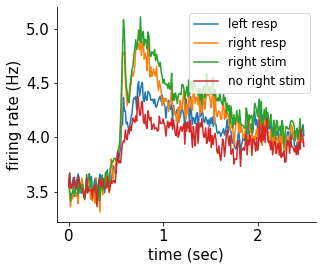

In [7]:
#@title basic plots of population average

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');
# HIDE CELL

In [8]:

# HIDE CELL

# gocue_time = (dat['gocue']*100+50).astype(int).flatten()
# print(gocue_time[:10])


# t_range = np.arange(-half_time_wind, half_time_wind)

# gocue_slice =dat['spks'][:,:, gocue_time[:,None] + t_range]
# print(gocue_slice.shape)

half_time_wind = 20

def get_gocue_slice(dat, half_time_wind=20):
    all_gocue_slice  = []
    for i in range(dat['spks'].shape[1]):
        gocue_time = (dat['gocue']*100+50).astype(int).flatten()
        gocue_slice =dat['spks'][:,i, gocue_time[i]-half_time_wind:gocue_time[i]+half_time_wind ]
        all_gocue_slice.append(gocue_slice)

    all_gocue_slice = np.stack(all_gocue_slice, axis=1)
    return all_gocue_slice

# all_gocue_slice = get_gocue_slice(dat, half_time_wind)
# print(all_gocue_slice.shape)

def get_gocue_slice_for_x(dat, x, half_time_wind=20):
    # dat is in shape (n_neurons, n_trials, n_time_bins)
    # x is in shape (n_trials, n_time_bins, comps)
    all_gocue_slice  = []
    for i in range(dat['spks'].shape[1]):
        gocue_time = (dat['gocue']*100+50).astype(int).flatten()
        gocue_slice = x[i, gocue_time[i]-half_time_wind:gocue_time[i]+half_time_wind ]
        all_gocue_slice.append(gocue_slice)

    all_gocue_slice = np.stack(all_gocue_slice, axis=0)
    return all_gocue_slice


In [9]:
# HIDE CELL

stimulus_onset_slice = dat['spks'][:,:,50-half_time_wind:50+half_time_wind]
print(stimulus_onset_slice.shape)


(698, 340, 40)


## Run dimension reduction and decoding decisions


By doing dimension reduction and decoding decisions, we can find out what brain regions contribute the most to the decision making process.

After doing dimension reduction, we can plot the reduced dimension time series data to check how the traces of different decisions differ.



## Dimension Reduction

In [10]:
# show the input data

all_spikes = dat['spks']
binned_multiplier = 1
NN = all_spikes.shape[0] # number of neurons
N_trials = all_spikes.shape[1] # number of trials
N_time = all_spikes.shape[2] # number of time_bins

# bin data into 100ms bins
binned_multiplier = 10
all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
all_spikes_bined = np.sum(all_spikes_bined, axis=-1)
print(all_spikes_bined.shape)
all_spikes = all_spikes_bined

print('neurons, trials, time_bins: ', all_spikes.shape)

# neurons, trials, time_bins
NN = all_spikes.shape[0] # number of neurons
N_trials = all_spikes.shape[1] # number of trials
N_time = all_spikes.shape[2] # number of time_bins
# HIDE CELL


(698, 340, 25)
neurons, trials, time_bins:  (698, 340, 25)


In [11]:
# only get the time between the stimulus onset and the go cue time

go_cues = dat['gocue']
print('go_cues: ', go_cues.shape)

response_times = dat['response_time']
print('response_times: ', response_times.shape)

# get the max time length
stim_onset = 51
max_len = int(np.ceil(100*np.max(go_cues))) + stim_onset
print(max_len)

data = np.reshape(all_spikes[:,:,stim_onset//binned_multiplier:max_len//binned_multiplier], (NN, -1)).T 
print(data.shape)

# HIDE CELL

go_cues:  (340, 1)
response_times:  (340, 1)
131
(2720, 698)


In [12]:
# get rid of neurons that don't fire for more than half of the trials 

# def get_rid_of_inactive_neurons(all_spikes):
#     int_data = np.sum(all_spikes, axis=-1)
#     # print('int_data: ', int_data.shape)
#     N_trials = all_spikes.shape[1]
#     n_half_trails = N_trials // 2
#     select_inds = []
#     for i, neuron in enumerate(int_data):
#         if np.count_nonzero(neuron) > n_half_trails:
#             select_inds.append(i)
#     return select_inds


# get rid of inactive neurons that fires less than 20 for more than half of the trials 

def get_rid_of_inactive_neurons(all_spikes, fire_num_limit:int=20):
    int_data = np.sum(all_spikes, axis=-1)
    # print('int_data: ', int_data.shape)
    N_trials = all_spikes.shape[1]
    n_half_trails = N_trials // 2
    select_inds = []
    for i, neuron in enumerate(int_data):
        if np.sum(neuron<=fire_num_limit) > n_half_trails:
            select_inds.append(i)
    return select_inds
# HIDE CELL

In [13]:

select_inds = get_rid_of_inactive_neurons(all_spikes)

# select_inds = get_rid_of_inactive_neurons(all_spikes[:,:,stim_onset//binned_multiplier:max_len//binned_multiplier])
print('selected: ', len(select_inds))

data = np.reshape(all_spikes, (NN, -1)).T 
print(data.shape)

data = data[:,select_inds]       
print('data: ', data.shape)
# HIDE CELL

selected:  594
(8500, 698)
data:  (8500, 594)


### DR - ICA

In [14]:
# use ICA 

from sklearn.decomposition import FastICA

ica_comp = 3
ica_transformer = FastICA(n_components=ica_comp, random_state=0)
ica_model = ica_transformer.fit(data)
# X_transformed_ica = transformer.fit_transform(data)
# print(X_transformed_ica.shape)

W_ica = ica_model.components_
pcs_all_time = W_ica @ np.reshape(all_spikes[select_inds], (len(select_inds),-1))
pcs_all_time = np.reshape(pcs_all_time, (ica_comp, N_trials, -1))
print('pcs_all_time: ', pcs_all_time.shape)
# HIDE CELL

pcs_all_time:  (3, 340, 25)


### DR - PCA

In [15]:
from sklearn.decomposition import PCA 



# use PCA

# PCA model 1: start with specifying 5 PCs

pca_model = PCA(n_components = 5).fit(data)
W = pca_model.components_
print('fit model, W: ', W.shape)

# project entire trial onto new PCs 
#pc_10ms = W @ np.reshape(dat['spks'], (NN,-1)) 
#print('pc_10ms', pc_10ms.shape)
#print('original data dimensions: ', (np.reshape(dat['spks'], (NN,-1))).shape)

#pc_10ms_3d = np.reshape(pc_10ms, (5, -1, NT))
#print('pc_10ms_3d dimensions:', pc_10ms_3d.shape)

# HIDE CELL

% Variance explained by first 5 PCs:  0.1414587593177017


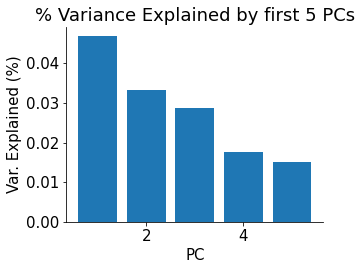

In [19]:
# check variance explained
# print(pca_model.explained_variance_ratio_)
print('% Variance explained by first 5 PCs: ', np.sum(pca_model.explained_variance_ratio_))
ax = plt.subplot(1,5,1)
plt.bar(np.arange(1,6),pca_model.explained_variance_ratio_)
plt.title('% Variance Explained by first 5 PCs' )
ax.set(xlabel  = 'PC', ylabel = 'Var. Explained (%)');

# model 1: 5 components account only for a minimal amount of variance: ~7.5%

In [20]:
# try PCA model 2

pca_model2 = PCA(n_components = 0.9).fit(data)
print('# of components needed to explain 90% variance: ', pca_model2.n_components_) # to account for 90% variance, we need 278 PCs. --> next step, break down into brain regions?
print('# of unique brain regions in this session: ', len(np.unique(dat['brain_area']))-1)
# print('unique brain regions in this session: ', np.unique(dat['brain_area']))

# of components needed to explain 90% variance:  253
# of unique brain regions in this session:  11


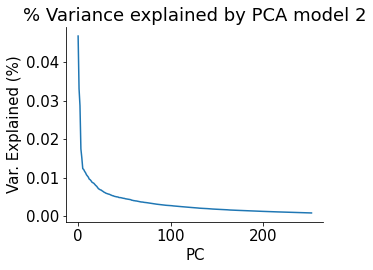

In [21]:
# plot variance explained by each PC

ax = plt.subplot(1,5,1)
plt.plot(pca_model2.explained_variance_ratio_)
plt.title('% Variance explained by PCA model 2' )
ax.set(xlabel  = 'PC', ylabel = 'Var. Explained (%)');

## Visualizing the dimension reduced time series data

## Decoding decision

In [22]:
# prepare the y labels for the x input

choice_responses = dat['response']
print(choice_responses.shape)

print('left trials: ', len(np.where(choice_responses < 0)[0]))
print('right trials: ', len(np.where(choice_responses > 0)[0]))
print('no response trials: ', len(np.where(choice_responses == 0)[0]))

idxs_left = np.where(choice_responses < 0)[0]
idxs_right = np.where(choice_responses > 0)[0]

idxs = np.append(idxs_left, idxs_right)

Y = choice_responses[idxs]
print(Y.shape)
# HIDE CELL

(340,)
left trials:  141
right trials:  135
no response trials:  64
(276,)


In [23]:
# for reward


comp = 3
all_X_transformed_ica_reward = []
all_X_transformed_ica_noreward = []


for i, dat in enumerate(alldat):
    # prepare data
    all_spikes = dat['spks']
    NN = all_spikes.shape[0]
    N_trials = all_spikes.shape[1]
#     print('N_trials: ', N_trials)

    # time bins of 100ms 
    binned_multiplier = 10
    all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
    all_spikes = np.sum(all_spikes_bined, axis=-1)

    data = np.reshape(all_spikes, (NN, -1)).T 

    # get rid of inactive neurons
    select_inds = get_rid_of_inactive_neurons(all_spikes)

    data = data[:,select_inds]

    transformer = FastICA(n_components=comp, random_state=0)
    X_transformed = transformer.fit_transform(data)
#     print('X_transformed: ', X_transformed.shape)

    # get the left and right trials indices
    reward = dat['feedback_type']  

    idxs_noreward = np.where(reward == 1)[0]
    idxs_reward = np.where(reward == -1)[0]
    print('reward len: ', len(idxs_reward))    
    print('noreward len: ', len(idxs_noreward))

    X_transformed_ica_viz = X_transformed.reshape((N_trials, -1, comp))
    print('X_transformed_ica_viz: ', X_transformed_ica_viz.shape) 
    
    X_transformed_ica_reward = np.mean(X_transformed_ica_viz[idxs_reward], axis=0)
    X_transformed_ica_noreward = np.mean(X_transformed_ica_viz[idxs_noreward], axis=0)
#     print('X_transformed_ica_go: ', X_transformed_ica_go.shape)
#     print('X_transformed_ica_nogo: ', X_transformed_ica_nogo.shape)
    all_X_transformed_ica_reward.append(X_transformed_ica_reward)
    all_X_transformed_ica_noreward.append(X_transformed_ica_noreward)
    
    print(f'finished sess {i}')

# HIDE CELL

reward len:  73
noreward len:  141
X_transformed_ica_viz:  (214, 25, 3)
finished sess 0
reward len:  92
noreward len:  159
X_transformed_ica_viz:  (251, 25, 3)
finished sess 1
reward len:  77
noreward len:  151
X_transformed_ica_viz:  (228, 25, 3)
finished sess 2
reward len:  83
noreward len:  166
X_transformed_ica_viz:  (249, 25, 3)
finished sess 3
reward len:  86
noreward len:  168
X_transformed_ica_viz:  (254, 25, 3)
finished sess 4
reward len:  75
noreward len:  215
X_transformed_ica_viz:  (290, 25, 3)
finished sess 5


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


reward len:  83
noreward len:  169
X_transformed_ica_viz:  (252, 25, 3)
finished sess 6
reward len:  89
noreward len:  161
X_transformed_ica_viz:  (250, 25, 3)
finished sess 7
reward len:  117
noreward len:  255
X_transformed_ica_viz:  (372, 25, 3)
finished sess 8
reward len:  170
noreward len:  277
X_transformed_ica_viz:  (447, 25, 3)
finished sess 9
reward len:  70
noreward len:  272
X_transformed_ica_viz:  (342, 25, 3)
finished sess 10
reward len:  89
noreward len:  251
X_transformed_ica_viz:  (340, 25, 3)
finished sess 11
reward len:  61
noreward len:  239
X_transformed_ica_viz:  (300, 25, 3)
finished sess 12
reward len:  82
noreward len:  186
X_transformed_ica_viz:  (268, 25, 3)
finished sess 13
reward len:  95
noreward len:  309
X_transformed_ica_viz:  (404, 25, 3)
finished sess 14


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


reward len:  79
noreward len:  201
X_transformed_ica_viz:  (280, 25, 3)
finished sess 15
reward len:  38
noreward len:  186
X_transformed_ica_viz:  (224, 25, 3)
finished sess 16
reward len:  69
noreward len:  247
X_transformed_ica_viz:  (316, 25, 3)
finished sess 17
reward len:  105
noreward len:  142
X_transformed_ica_viz:  (247, 25, 3)
finished sess 18
reward len:  96
noreward len:  139
X_transformed_ica_viz:  (235, 25, 3)
finished sess 19
reward len:  58
noreward len:  66
X_transformed_ica_viz:  (124, 25, 3)
finished sess 20
reward len:  133
noreward len:  311
X_transformed_ica_viz:  (444, 25, 3)
finished sess 21
reward len:  49
noreward len:  102
X_transformed_ica_viz:  (151, 25, 3)
finished sess 22
reward len:  78
noreward len:  109
X_transformed_ica_viz:  (187, 25, 3)
finished sess 23


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


reward len:  73
noreward len:  188
X_transformed_ica_viz:  (261, 25, 3)
finished sess 24
reward len:  48
noreward len:  130
X_transformed_ica_viz:  (178, 25, 3)
finished sess 25
reward len:  94
noreward len:  159
X_transformed_ica_viz:  (253, 25, 3)
finished sess 26
reward len:  57
noreward len:  85
X_transformed_ica_viz:  (142, 25, 3)
finished sess 27
reward len:  53
noreward len:  75
X_transformed_ica_viz:  (128, 25, 3)
finished sess 28
reward len:  71
noreward len:  72
X_transformed_ica_viz:  (143, 25, 3)
finished sess 29
reward len:  73
noreward len:  164
X_transformed_ica_viz:  (237, 25, 3)
finished sess 30
reward len:  74
noreward len:  186
X_transformed_ica_viz:  (260, 25, 3)
finished sess 31
reward len:  62
noreward len:  129
X_transformed_ica_viz:  (191, 25, 3)
finished sess 32
reward len:  120
noreward len:  176
X_transformed_ica_viz:  (296, 25, 3)
finished sess 33
reward len:  71
noreward len:  240
X_transformed_ica_viz:  (311, 25, 3)
finished sess 34
reward len:  70
norewar

/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


reward len:  49
noreward len:  132
X_transformed_ica_viz:  (181, 25, 3)
finished sess 36
reward len:  68
noreward len:  131
X_transformed_ica_viz:  (199, 25, 3)
finished sess 37
reward len:  97
noreward len:  246
X_transformed_ica_viz:  (343, 25, 3)
finished sess 38


### Visualize ICA components

<ipython-input-25-92ae4b701dcb>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


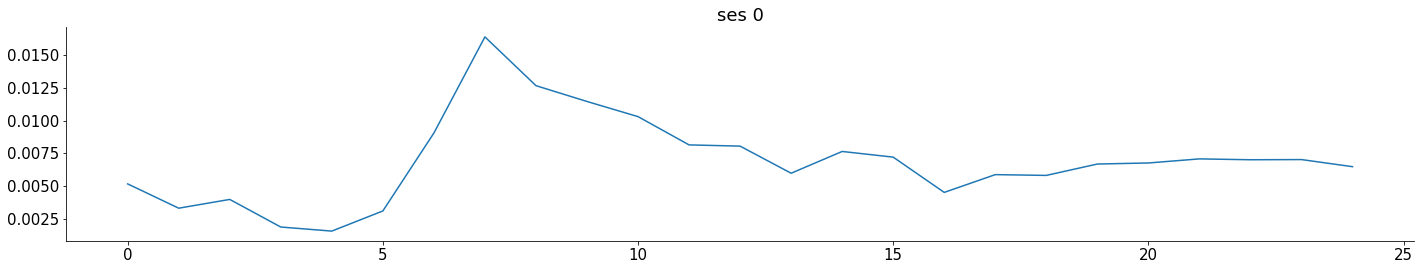

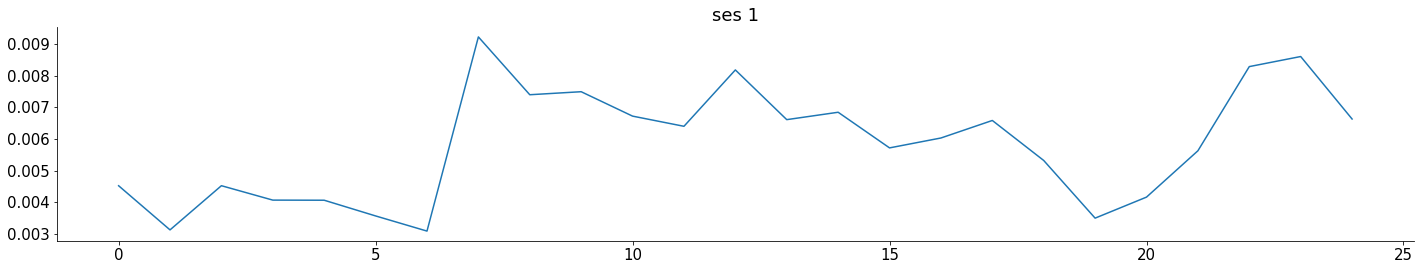

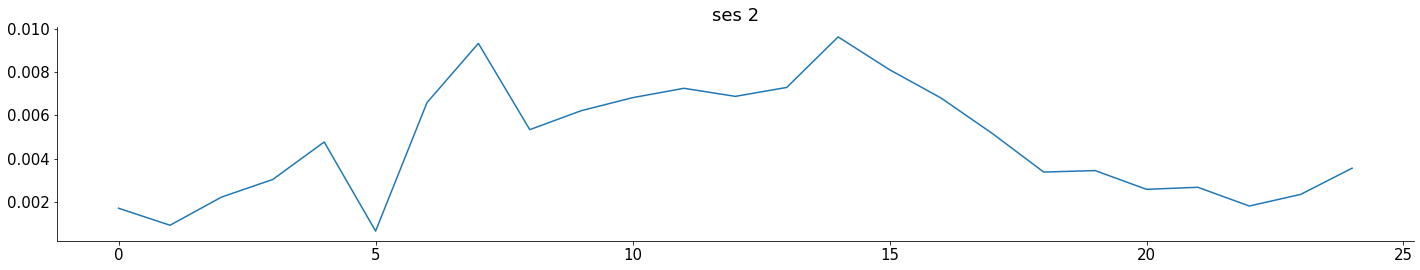

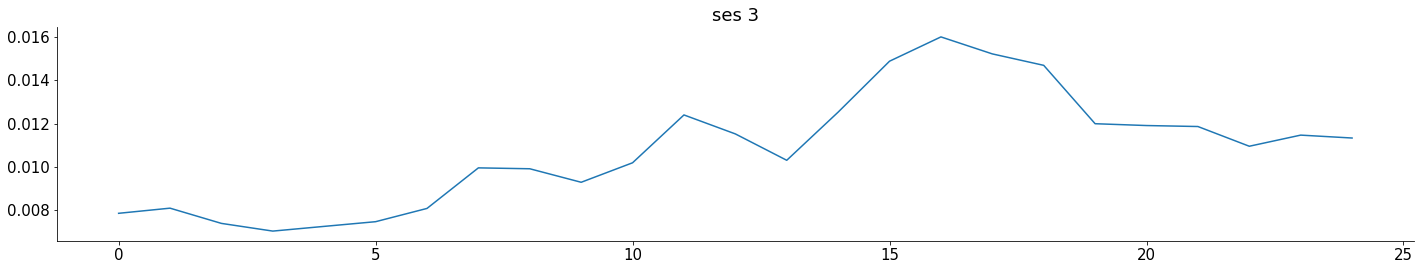

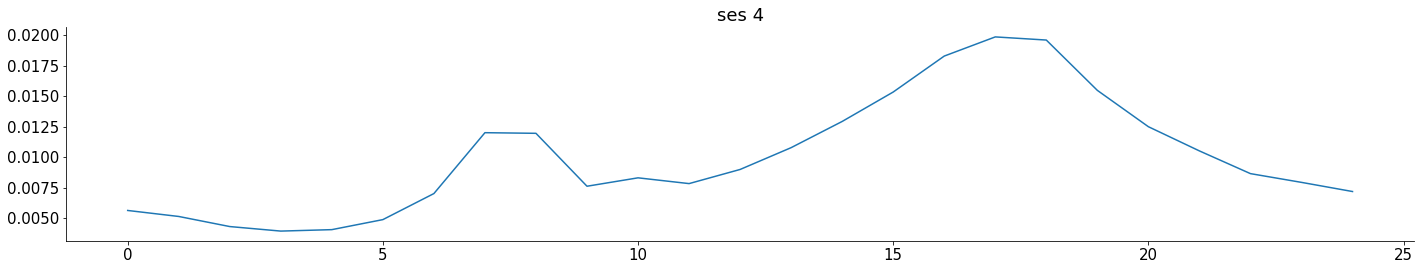

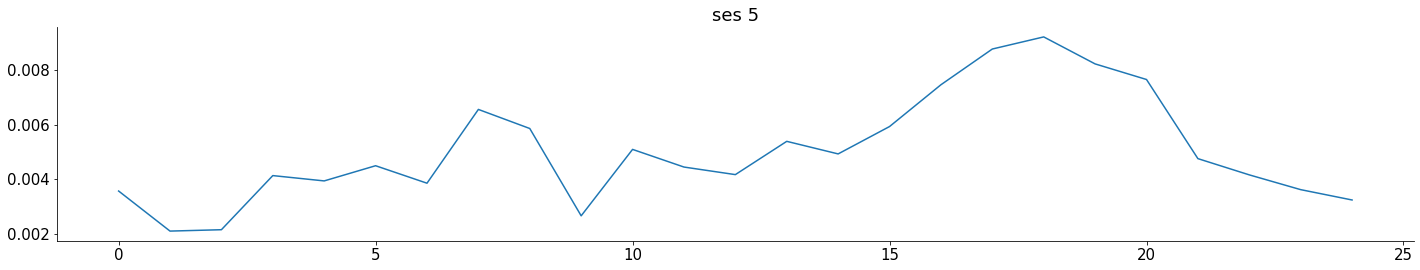

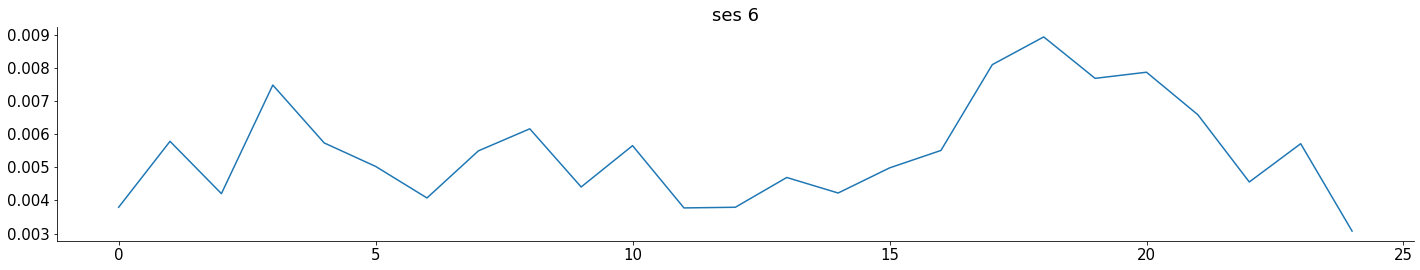

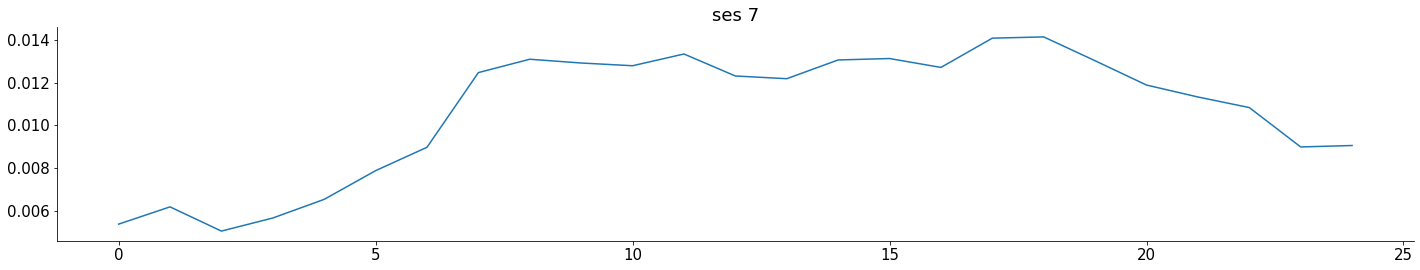

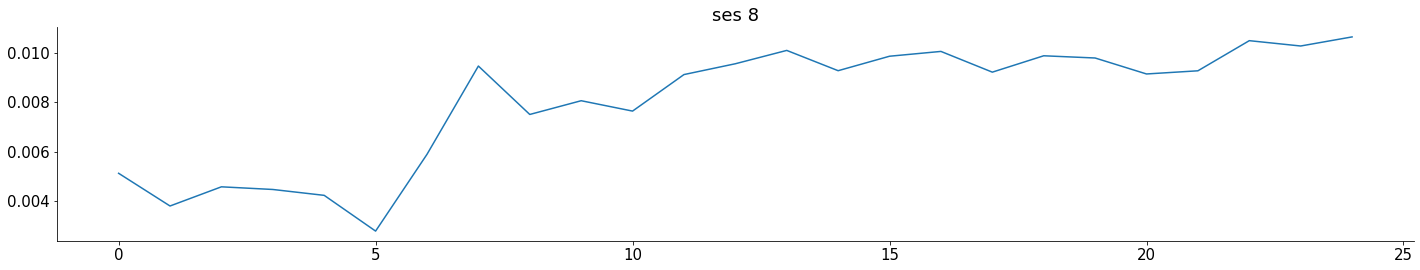

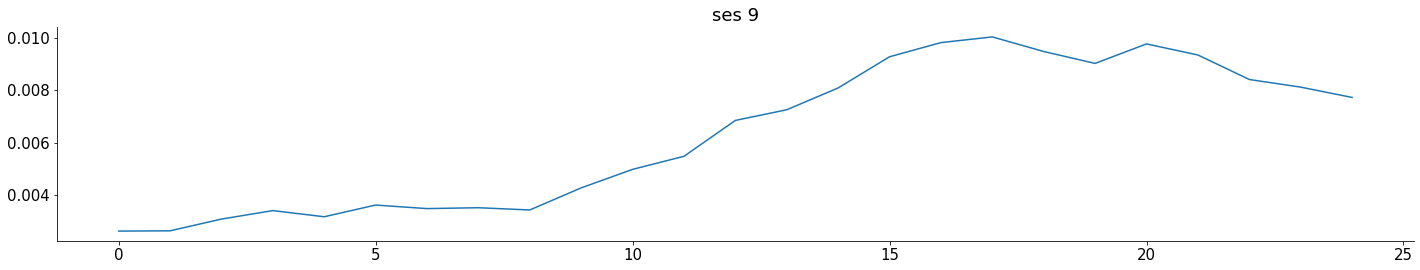

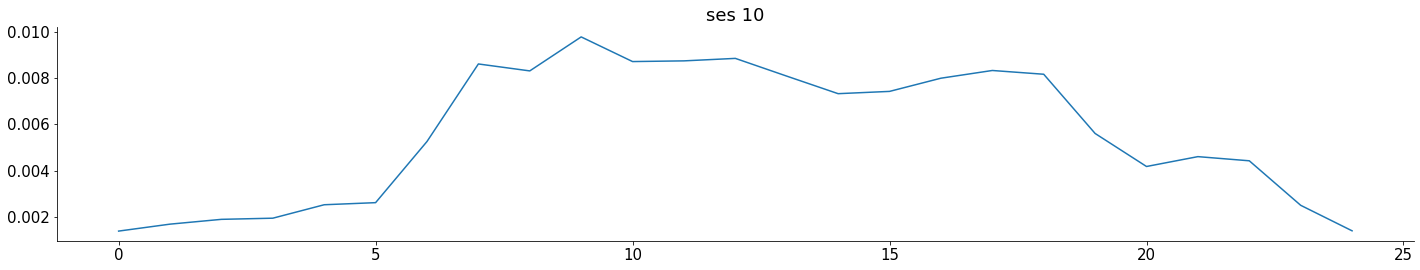

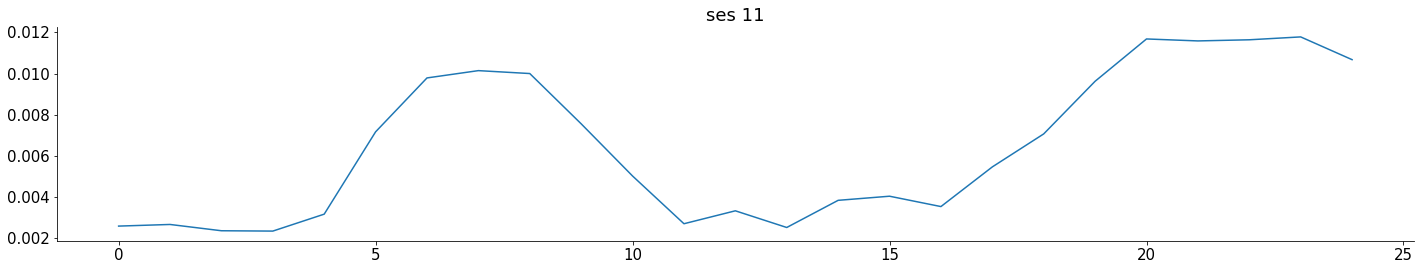

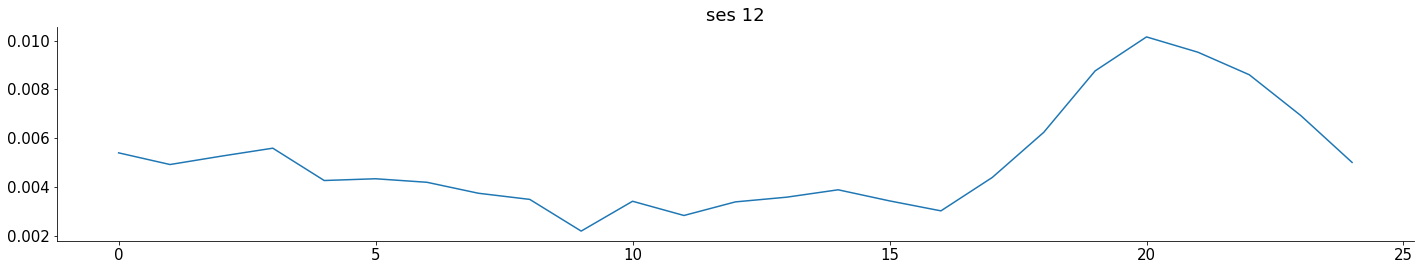

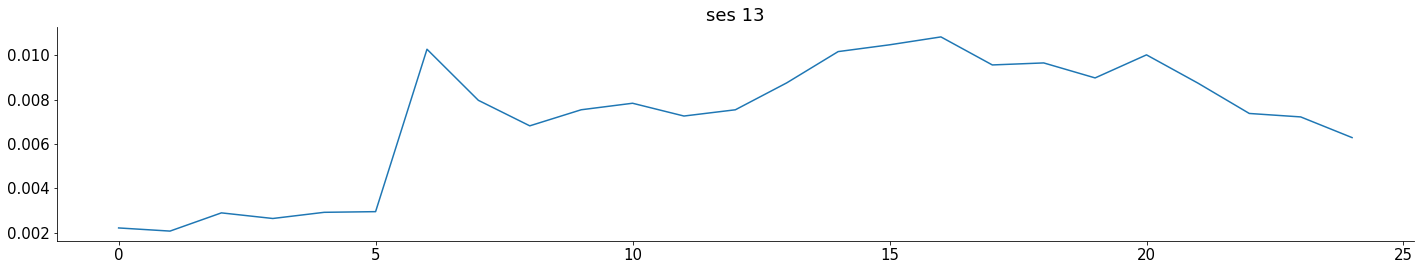

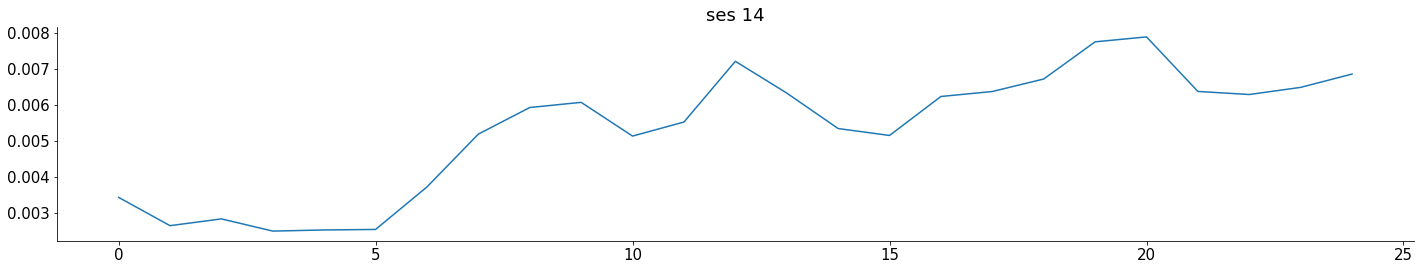

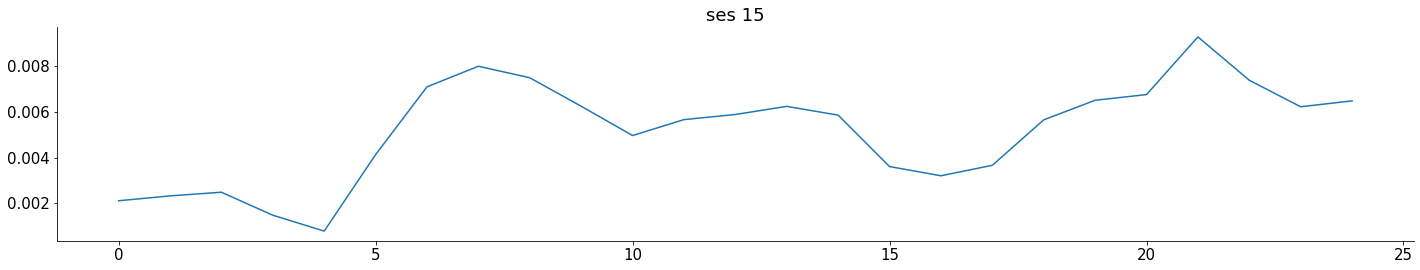

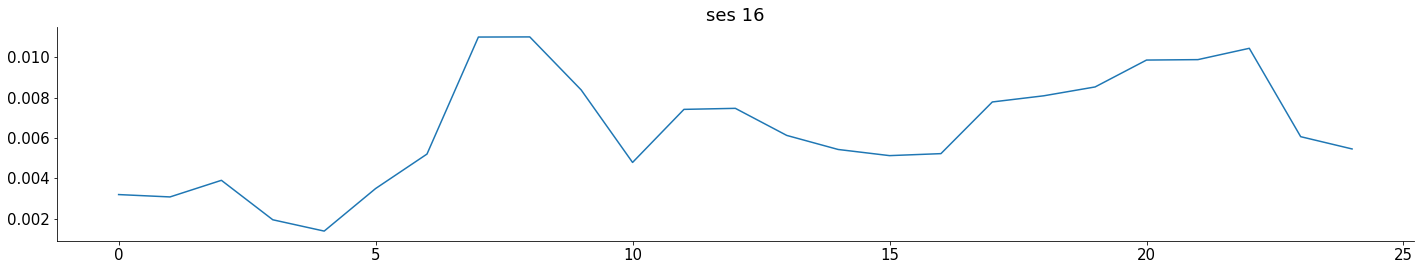

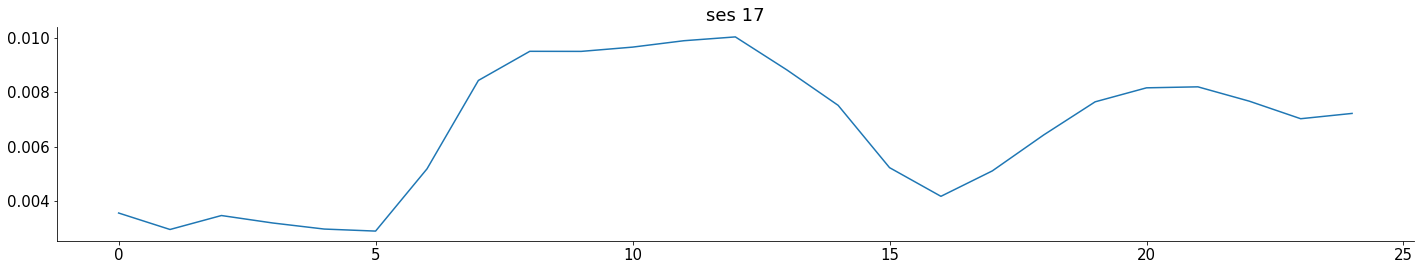

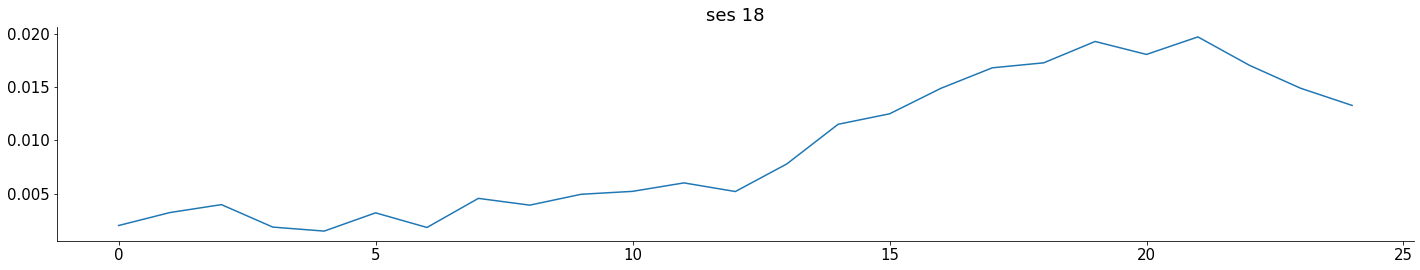

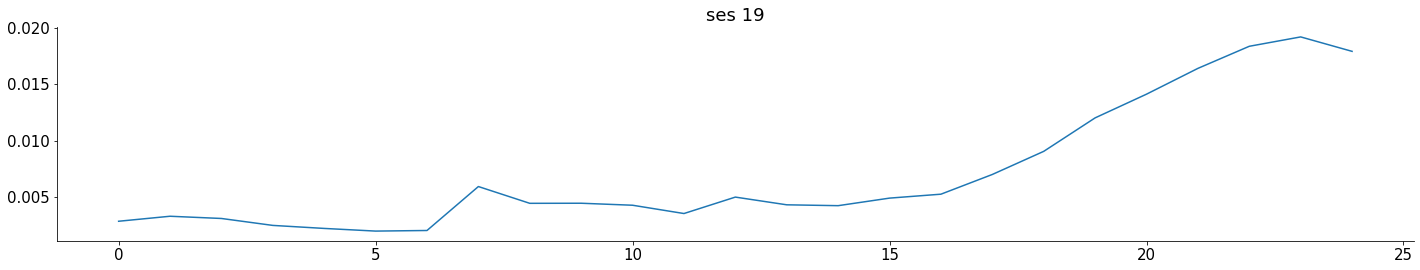

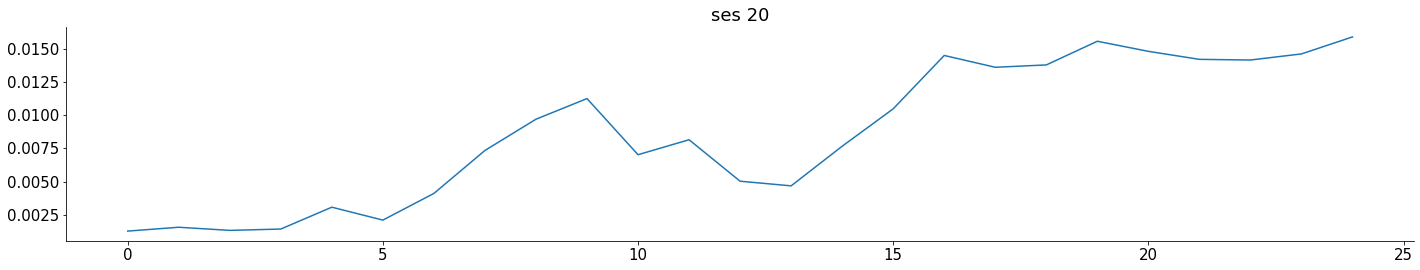

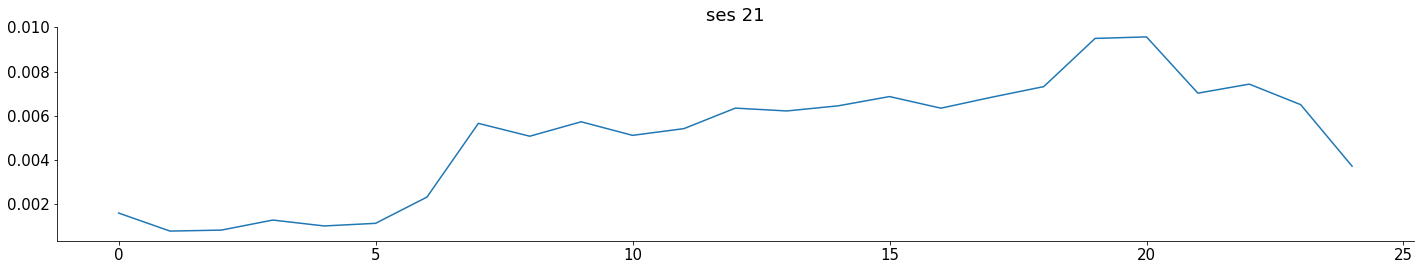

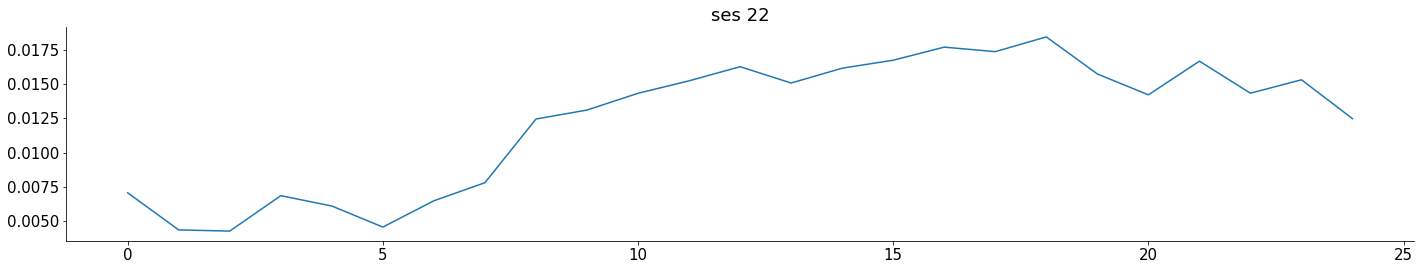

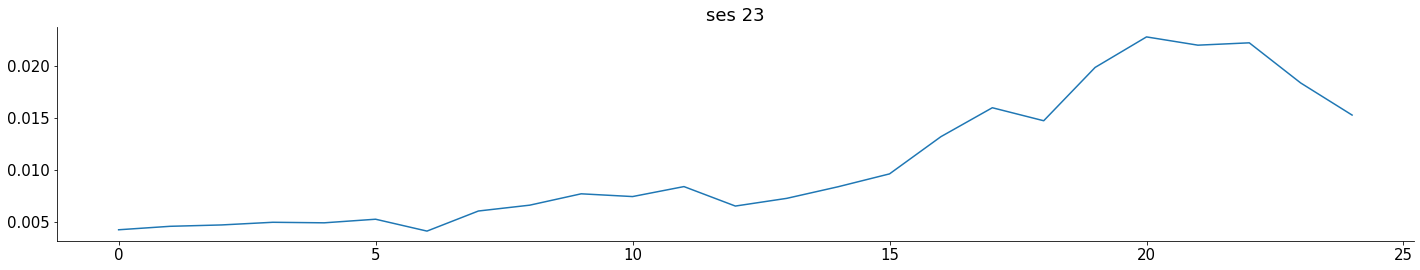

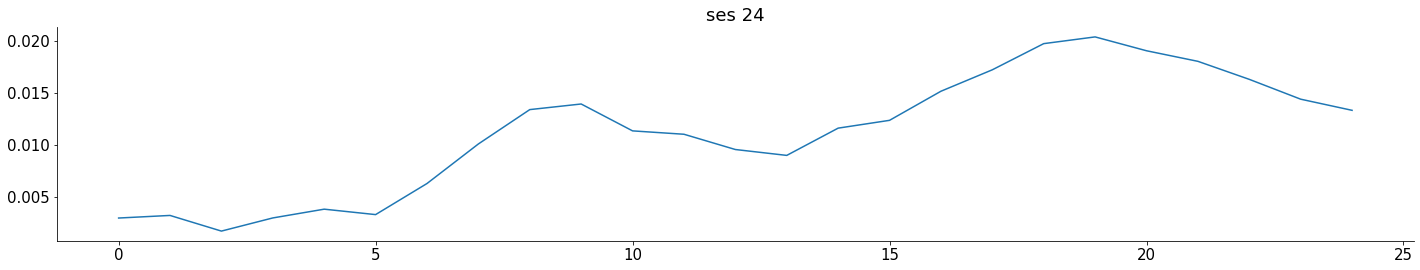

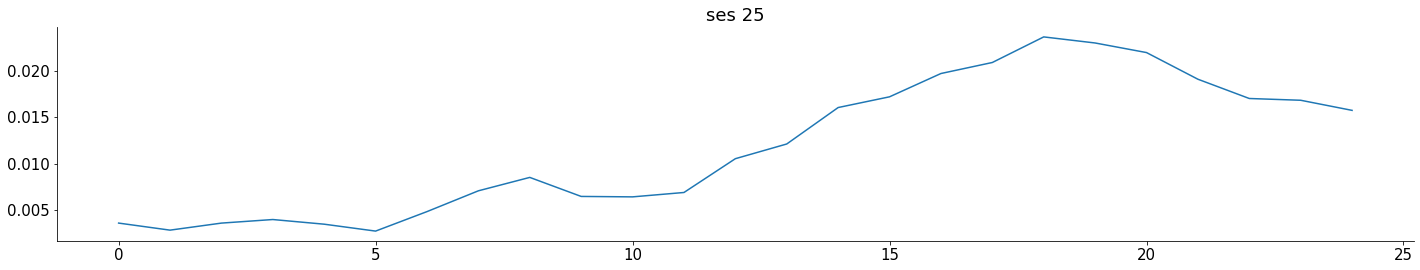

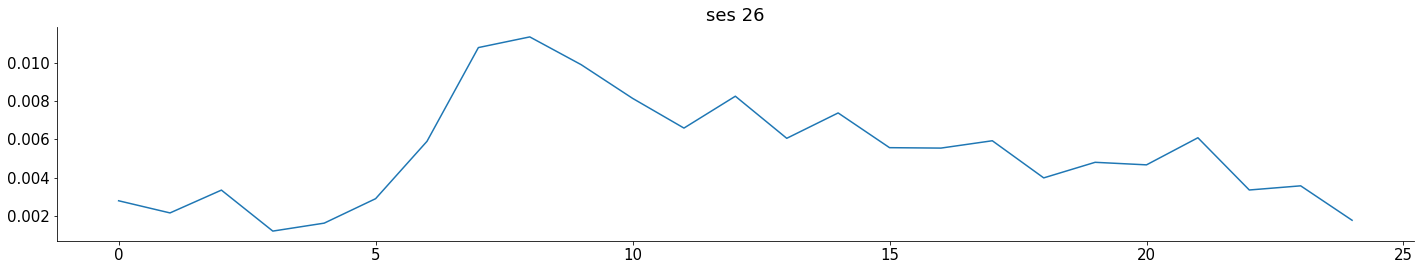

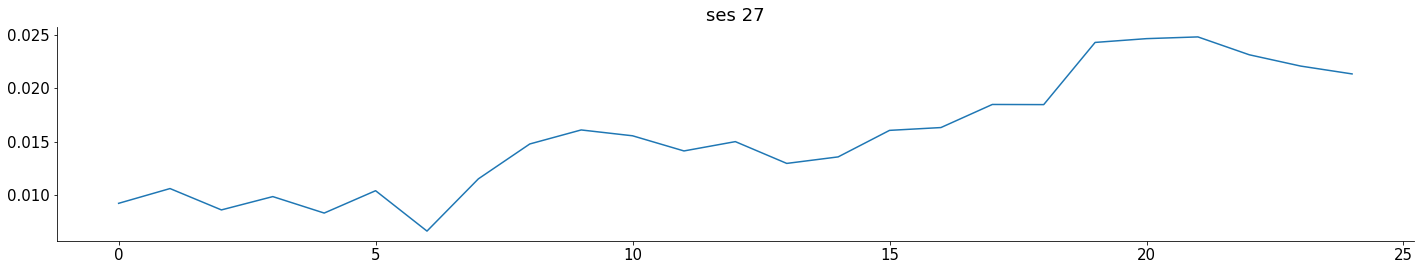

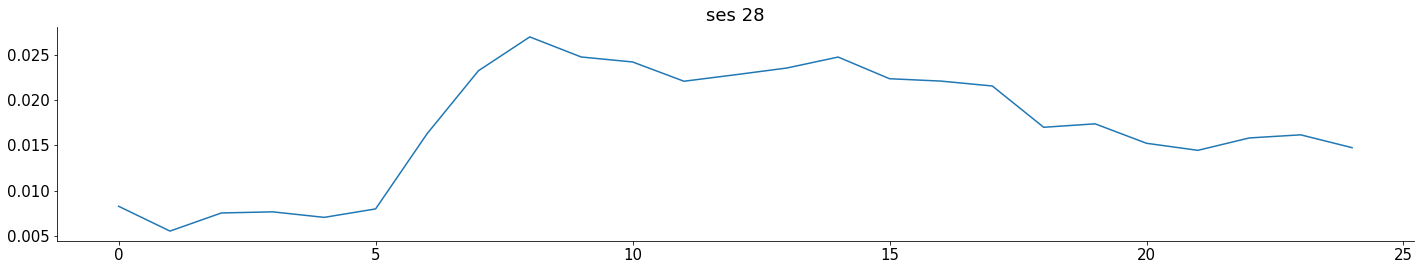

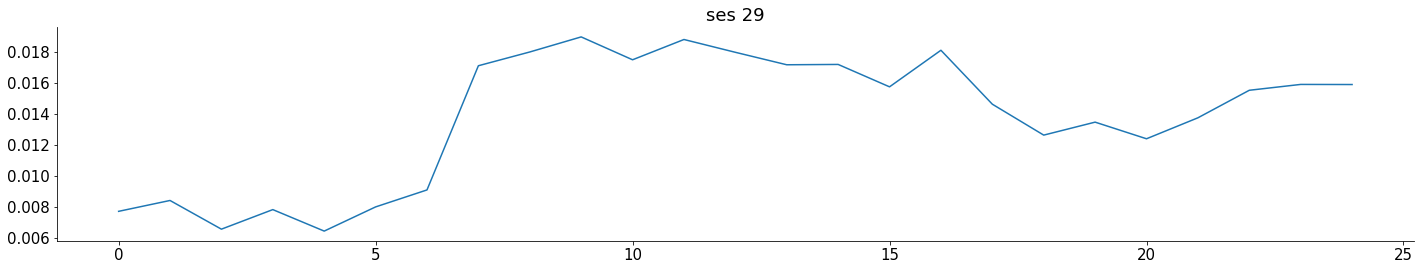

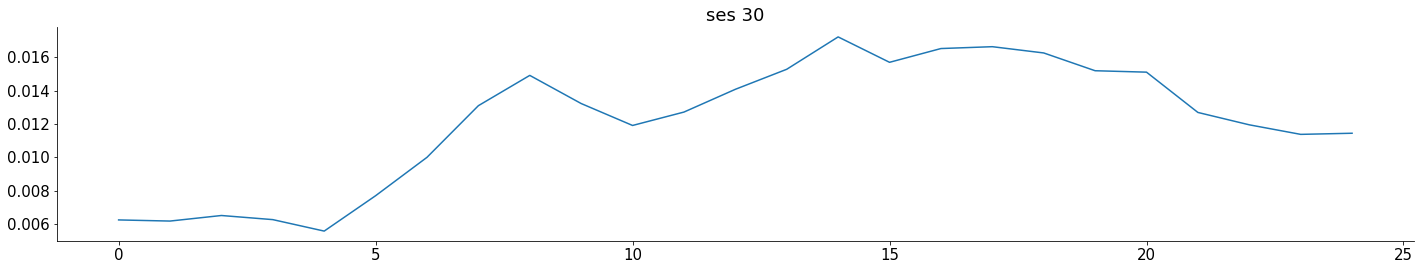

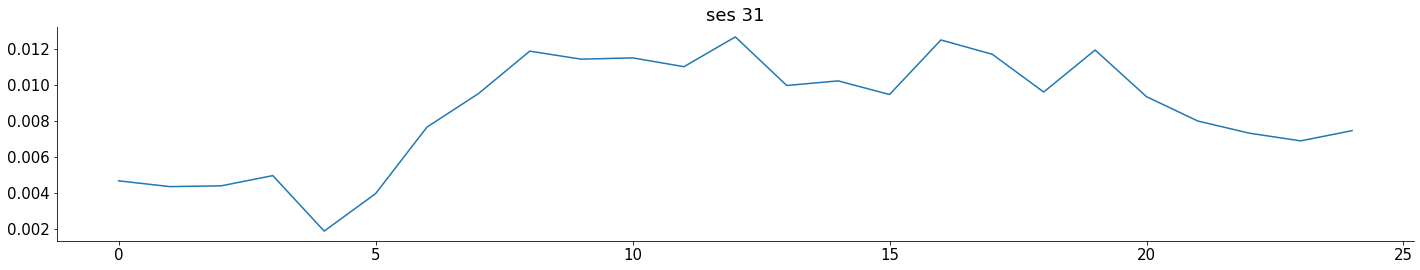

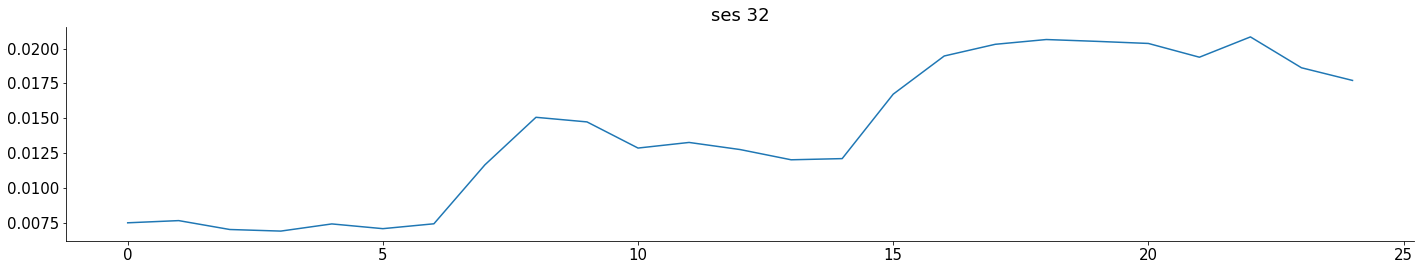

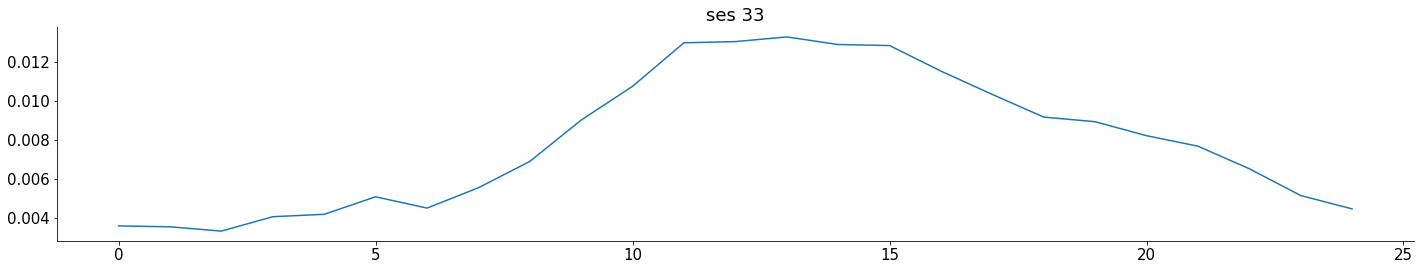

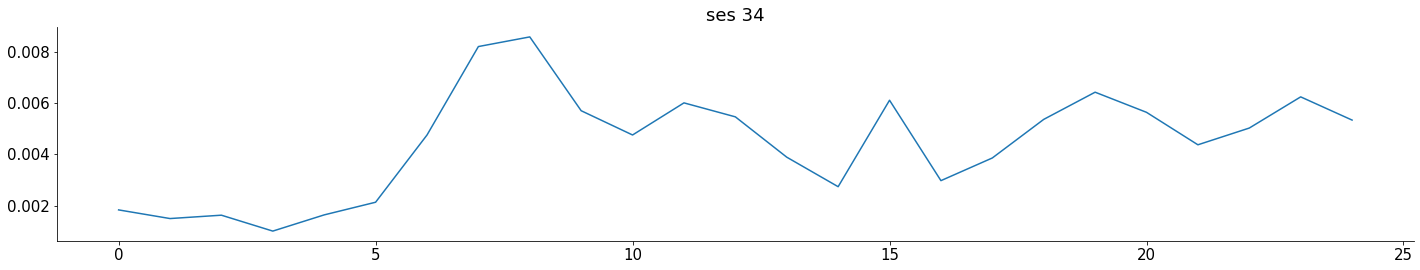

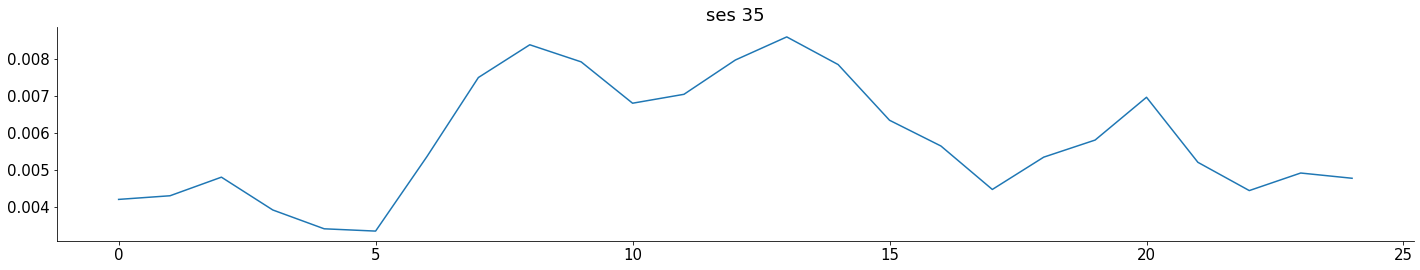

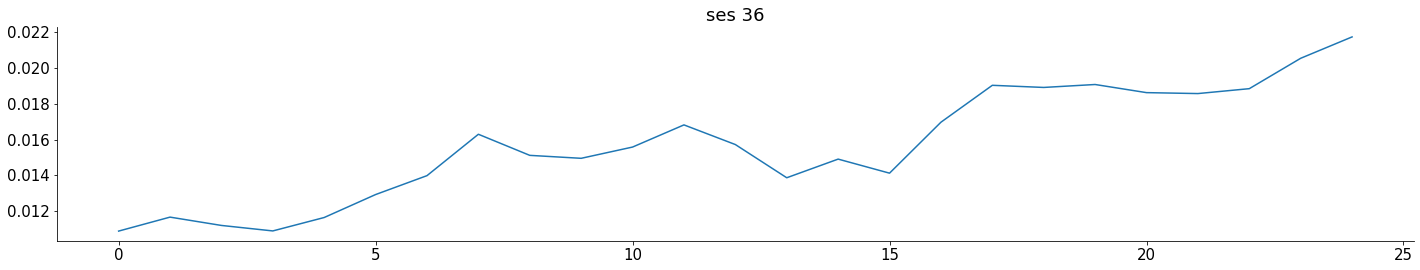

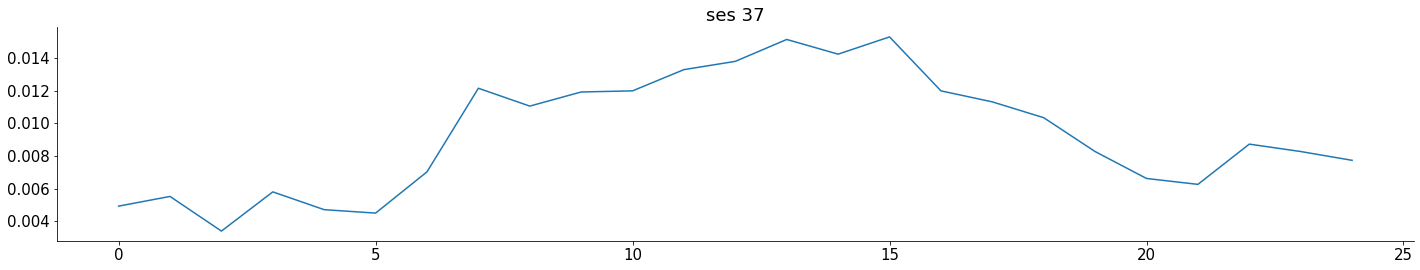

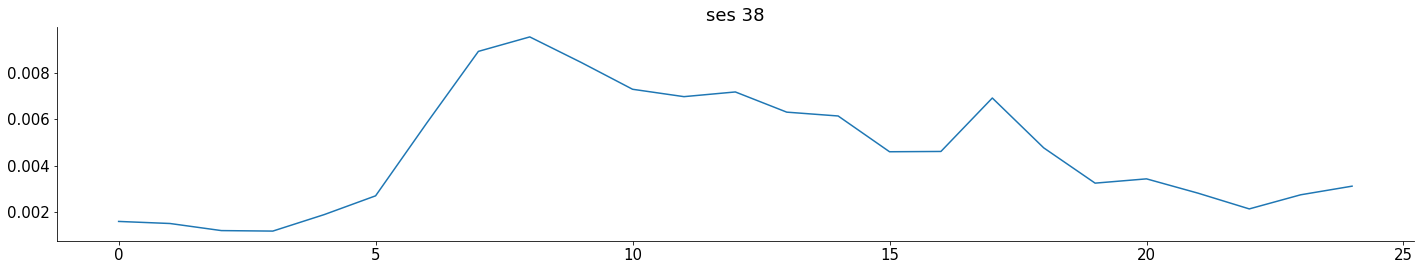

In [25]:
for ses in range(39):
    dists_3d = []

    X_transformed_ica_reward = all_X_transformed_ica_reward[ses]
    X_transformed_ica_noreward = all_X_transformed_ica_noreward[ses]


    for i in range(X_transformed_ica_reward.shape[0]):
        dist = np.linalg.norm(X_transformed_ica_reward[i]-X_transformed_ica_noreward[i], ord=2)
        dists_3d.append(dist)
    fig = plt.figure()
    plt.plot(dists_3d)
    plt.title(f'ses {ses}')
# HIDE CODE


In [27]:

%matplotlib notebook

# plotting 3D

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')


X_transformed_ica_left = all_X_transformed_ica_reward[27]
X_transformed_ica_right = all_X_transformed_ica_noreward[27]


ax.plot(X_transformed_ica_left[:,0], X_transformed_ica_left[:,1], X_transformed_ica_left[:,2], linewidth=4, c='m', label='Average correct trails')
ax.plot(X_transformed_ica_right[:,0], X_transformed_ica_right[:,1], X_transformed_ica_right[:,2], linewidth=4, c='c', label='Average incorrect trails')

N_points = X_transformed_ica_left.shape[0]
marker_points_inx = [0, 5, 13, N_points-1]

ax.scatter(X_transformed_ica_left[marker_points_inx,0], X_transformed_ica_left[marker_points_inx,1],X_transformed_ica_left[marker_points_inx,2], c=['g', 'b','y', 'r'], linewidth=6)
ax.scatter(X_transformed_ica_right[marker_points_inx,0], X_transformed_ica_right[marker_points_inx,1],X_transformed_ica_right[marker_points_inx,2], c=['g', 'b','y', 'r'], linewidth=6)

ax.set_title('Trajectories projected in the ICA reduced 3 components')


ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(False)

ax.set_xlabel('Component 1')                
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')


# Set the angle of the camera
ax.view_init(20, 45)

plt.legend()
plt.tight_layout()
plt.show()

plt.savefig(f'figs/3D_trajectories_reward.svg')

# HIDE CODE

<IPython.core.display.Javascript object>

Select specific brain regions

<IPython.core.display.Javascript object>


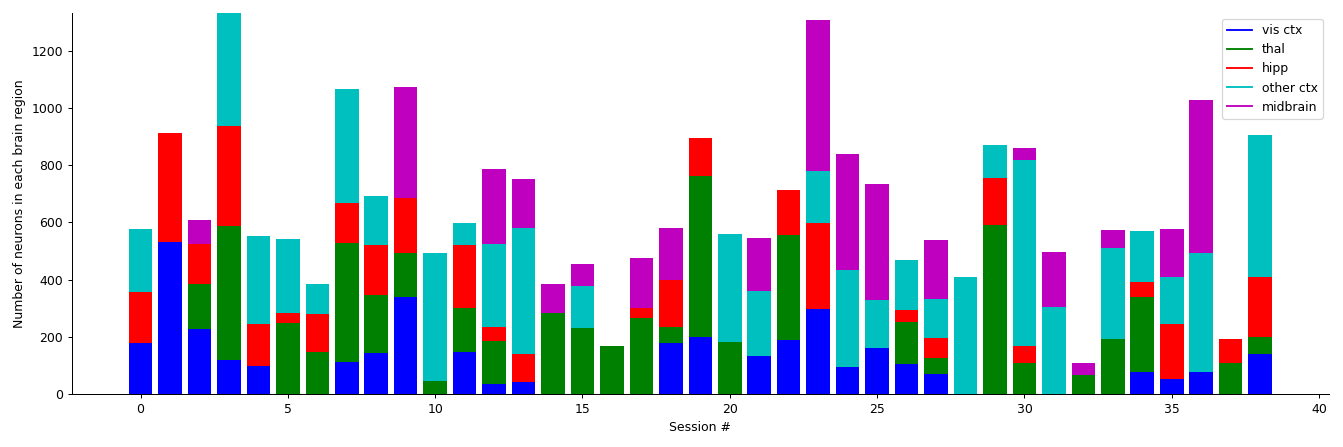

In [32]:

'''
Make nsession x 5 brain regions. Each element is vector of which neurons are in the brain region
'''
import matplotlib.pyplot as plt 

regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

f=plt.figure(figsize=(15,5));
neurons_for_decoding = np.empty(shape=(39,5),dtype='object');

col_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

threshold = 30 

for iregion in range(5):
    # Plot placeholders for label
    plt.plot(np.inf,np.inf,color=col_list[iregion], label=regions[iregion]); 
 
    for isession in range(39):
        dat = alldat[isession];
        brain_area = dat['brain_area'];
        neurons_for_decoding[isession, iregion] = np.zeros(shape=(len(brain_area),),dtype='int')
        
        for i_small_region, small_region in enumerate(brain_groups[iregion]):
            kk = np.where(brain_area == small_region)[0]; 
            neurons_for_decoding[isession, iregion][kk] = 1;
            
        if np.sum(neurons_for_decoding[isession,iregion]) < threshold:
            neurons_for_decoding[isession,iregion] = np.zeros(shape=(len(brain_area),),dtype='int') 
            
            
        total = 0
        for i in range(iregion):
            total += np.sum(neurons_for_decoding[isession, i])
        plt.bar(isession, np.sum(neurons_for_decoding[isession,iregion]), bottom = total, color=col_list[iregion]);
        
        
plt.xlabel('Session #'); 
plt.ylabel('Number of neurons in each brain region');
plt.legend(); 
plt.show();



In [33]:
# for go/nogo and right contrast in different brain regions

from sklearn.decomposition import FastICA 

comp = 3
# all_X_transformed_ica_go = []
# all_X_transformed_ica_nogo = []

# all_X_transformed_ica_stimulus = []
# all_X_transformed_ica_nostimulus = []

for i, dat in enumerate(alldat[24:25]):
    i = 24
    dat = alldat[24]
    
    go_ica_comps = []    
    nogo_ica_comps = []

    right_stim_ica_comps = []
    noright_stim_ica_comps = []
    
    for brain_region_i in [0,4]:
        # prepare data
        all_spikes = dat['spks']

        if np.sum(neurons_for_decoding[i, brain_region_i]) == 0:
            # correct_scores.append(-1)
            go_ica_comps.append(-1)
            nogo_ica_comps.append(-1)
            right_stim_ica_comps.append(-1)
            noright_stim_ica_comps.append(-1)
            continue
            
        print('brain_region_i: ', brain_region_i)
        all_spikes = all_spikes[neurons_for_decoding[i, brain_region_i].astype('bool')]
        print('all_spikes: ', all_spikes.shape)

        NN = all_spikes.shape[0]
        N_trials = all_spikes.shape[1]
        print('N_trials: ', N_trials)

        # # time bins of 100ms 
        # binned_multiplier = 10
        # all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
        # all_spikes = np.sum(all_spikes_bined, axis=-1)

        data = np.reshape(all_spikes, (NN, -1)).T 
        print('data: ', data.shape)

        # get rid of inactive neurons
        # select_inds = get_rid_of_inactive_neurons(all_spikes)
        # data = data[:,select_inds]

        transformer = FastICA(n_components=comp, random_state=0)
        X_transformed = transformer.fit_transform(data)
        print('X_transformed: ', X_transformed.shape)


        X_transformed_ica_viz = X_transformed.reshape((N_trials, -1, comp))
        print('X_transformed_ica_viz: ', X_transformed_ica_viz.shape) 

        # get the left and right trials indices
        choice_responses = dat['response']    

        idxs_nogo = np.where(choice_responses == 0)[0]
        idxs_go = np.where(choice_responses != 0)[0]
        print('go len: ', len(idxs_go))    
        print('nogo len: ', len(idxs_nogo))

        X_transformed_ica_go = np.mean(X_transformed_ica_viz[idxs_go], axis=0)
        X_transformed_ica_nogo = np.mean(X_transformed_ica_viz[idxs_nogo], axis=0)
    #     print('X_transformed_ica_go: ', X_transformed_ica_go.shape)
    #     print('X_transformed_ica_nogo: ', X_transformed_ica_nogo.shape)
    
        go_ica_comps.append(X_transformed_ica_go)
        nogo_ica_comps.append(X_transformed_ica_nogo)
    
        # get yes/no right stimulus trials
        right_contrast = dat['contrast_right']
        idxs_nostimulus = np.where(right_contrast == 0)[0]
        idxs_stimulus = np.where(right_contrast != 0)[0]
        print('stim len: ', len(idxs_stimulus))    
        print('nostim len: ', len(idxs_nostimulus))
        
        X_transformed_ica_stimulus = np.mean(X_transformed_ica_viz[idxs_stimulus], axis=0)
        X_transformed_ica_nostimulus = np.mean(X_transformed_ica_viz[idxs_nostimulus], axis=0)
    
        right_stim_ica_comps.append(X_transformed_ica_stimulus)
        noright_stim_ica_comps.append(X_transformed_ica_nostimulus)
    
#     all_X_transformed_ica_go.append(go_ica_comps)
#     all_X_transformed_ica_nogo.append(nogo_ica_comps)
#     all_X_transformed_ica_stimulus.append(right_stim_ica_comps)
#     all_X_transformed_ica_nostimulus.append(noright_stim_ica_comps)
    
    print(f'finished sess {i}')
# HIDE CODE

brain_region_i:  0
all_spikes:  (94, 261, 250)
N_trials:  261
data:  (65250, 94)
X_transformed:  (65250, 3)
X_transformed_ica_viz:  (261, 250, 3)
go len:  185
nogo len:  76
stim len:  136
nostim len:  125
brain_region_i:  4
all_spikes:  (404, 261, 250)
N_trials:  261
data:  (65250, 404)
X_transformed:  (65250, 3)
X_transformed_ica_viz:  (261, 250, 3)
go len:  185
nogo len:  76
stim len:  136
nostim len:  125
finished sess 24


In [34]:
# for go/nogo and right contrast in different brain regions

from sklearn.decomposition import FastICA 

comp = 3
all_X_transformed_ica_go = []
all_X_transformed_ica_nogo = []

all_X_transformed_ica_stimulus = []
all_X_transformed_ica_nostimulus = []

for i, dat in enumerate(alldat):
    
    go_ica_comps = []    
    nogo_ica_comps = []

    right_stim_ica_comps = []
    noright_stim_ica_comps = []
    
    for brain_region_i in [0,4]:
        # prepare data
        all_spikes = dat['spks']

        if np.sum(neurons_for_decoding[i, brain_region_i]) == 0:
            # correct_scores.append(-1)
            go_ica_comps.append(-1)
            nogo_ica_comps.append(-1)
            right_stim_ica_comps.append(-1)
            noright_stim_ica_comps.append(-1)
            continue

        all_spikes = all_spikes[neurons_for_decoding[i, brain_region_i].astype('bool')]

        NN = all_spikes.shape[0]
        N_trials = all_spikes.shape[1]
    #     print('N_trials: ', N_trials)

        # # time bins of 100ms 
        # binned_multiplier = 10
        # all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
        # all_spikes = np.sum(all_spikes_bined, axis=-1)

        data = np.reshape(all_spikes, (NN, -1)).T 

        # get rid of inactive neurons
        # select_inds = get_rid_of_inactive_neurons(all_spikes)
        # data = data[:,select_inds]

        transformer = FastICA(n_components=comp, random_state=0)
        X_transformed = transformer.fit_transform(data)
    #     print('X_transformed: ', X_transformed.shape)


        X_transformed_ica_viz = X_transformed.reshape((N_trials, -1, comp))
        print('X_transformed_ica_viz: ', X_transformed_ica_viz.shape) 

        # get the left and right trials indices
        choice_responses = dat['response']    

        idxs_nogo = np.where(choice_responses == 0)[0]
        idxs_go = np.where(choice_responses != 0)[0]
    #     print('go len: ', len(idxs_go))    
    #     print('nogo len: ', len(idxs_nogo))

        X_transformed_ica_go = np.mean(X_transformed_ica_viz[idxs_go], axis=0)
        X_transformed_ica_nogo = np.mean(X_transformed_ica_viz[idxs_nogo], axis=0)
    #     print('X_transformed_ica_go: ', X_transformed_ica_go.shape)
    #     print('X_transformed_ica_nogo: ', X_transformed_ica_nogo.shape)
    
        go_ica_comps.append(X_transformed_ica_go)
        nogo_ica_comps.append(X_transformed_ica_nogo)
    
        # get yes/no right stimulus trials
        right_contrast = dat['contrast_right']
        idxs_nostimulus = np.where(right_contrast == 0)[0]
        idxs_stimulus = np.where(right_contrast != 0)[0]
        
        X_transformed_ica_stimulus = np.mean(X_transformed_ica_viz[idxs_stimulus], axis=0)
        X_transformed_ica_nostimulus = np.mean(X_transformed_ica_viz[idxs_nostimulus], axis=0)
    
        right_stim_ica_comps.append(X_transformed_ica_stimulus)
        noright_stim_ica_comps.append(X_transformed_ica_nostimulus)
    
    all_X_transformed_ica_go.append(go_ica_comps)
    all_X_transformed_ica_nogo.append(nogo_ica_comps)
    all_X_transformed_ica_stimulus.append(right_stim_ica_comps)
    all_X_transformed_ica_nostimulus.append(noright_stim_ica_comps)
    
    print(f'finished sess {i}')


X_transformed_ica_viz:  (214, 250, 3)
finished sess 0
X_transformed_ica_viz:  (251, 250, 3)
finished sess 1
X_transformed_ica_viz:  (228, 250, 3)
X_transformed_ica_viz:  (228, 250, 3)
finished sess 2
X_transformed_ica_viz:  (249, 250, 3)
finished sess 3
X_transformed_ica_viz:  (254, 250, 3)
finished sess 4
finished sess 5
finished sess 6
X_transformed_ica_viz:  (250, 250, 3)
finished sess 7
X_transformed_ica_viz:  (372, 250, 3)
finished sess 8
X_transformed_ica_viz:  (447, 250, 3)
X_transformed_ica_viz:  (447, 250, 3)
finished sess 9
finished sess 10
X_transformed_ica_viz:  (340, 250, 3)
finished sess 11
X_transformed_ica_viz:  (300, 250, 3)
X_transformed_ica_viz:  (300, 250, 3)
finished sess 12
X_transformed_ica_viz:  (268, 250, 3)


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


X_transformed_ica_viz:  (268, 250, 3)
finished sess 13
X_transformed_ica_viz:  (404, 250, 3)
finished sess 14
X_transformed_ica_viz:  (280, 250, 3)
finished sess 15
finished sess 16
X_transformed_ica_viz:  (316, 250, 3)
finished sess 17
X_transformed_ica_viz:  (247, 250, 3)
X_transformed_ica_viz:  (247, 250, 3)
finished sess 18
X_transformed_ica_viz:  (235, 250, 3)
finished sess 19
finished sess 20
X_transformed_ica_viz:  (444, 250, 3)
X_transformed_ica_viz:  (444, 250, 3)
finished sess 21
X_transformed_ica_viz:  (151, 250, 3)
finished sess 22
X_transformed_ica_viz:  (187, 250, 3)
X_transformed_ica_viz:  (187, 250, 3)
finished sess 23
X_transformed_ica_viz:  (261, 250, 3)
X_transformed_ica_viz:  (261, 250, 3)
finished sess 24
X_transformed_ica_viz:  (178, 250, 3)
X_transformed_ica_viz:  (178, 250, 3)
finished sess 25
X_transformed_ica_viz:  (253, 250, 3)
finished sess 26
X_transformed_ica_viz:  (142, 250, 3)
X_transformed_ica_viz:  (142, 250, 3)
finished sess 27
finished sess 28
finish

In [35]:
# process the results 

# get the 4 types of output for a session
session_n = 24 
def get_session_results(session_n, all_X_transformed_ica_go, all_X_transformed_ica_nogo, all_X_transformed_ica_stimulus, all_X_transformed_ica_nostimulus):
    X_transformed_ica_go_vis = all_X_transformed_ica_go[session_n][0]
    X_transformed_ica_nogo_vis = all_X_transformed_ica_nogo[session_n][0]
    X_transformed_ica_go_midbrain = all_X_transformed_ica_go[session_n][1]
    X_transformed_ica_nogo_midbrain = all_X_transformed_ica_nogo[session_n][1]

    X_transformed_ica_stimulus_vis = all_X_transformed_ica_stimulus[session_n][0]
    X_transformed_ica_nostimulus_vis = all_X_transformed_ica_nostimulus[session_n][0]
    X_transformed_ica_stimulus_midbrain = all_X_transformed_ica_stimulus[session_n][1]
    X_transformed_ica_nostimulus_midbrain = all_X_transformed_ica_nostimulus[session_n][1]
    return (X_transformed_ica_go_vis, X_transformed_ica_nogo_vis, X_transformed_ica_go_midbrain, X_transformed_ica_nogo_midbrain,
            X_transformed_ica_stimulus_vis, X_transformed_ica_nostimulus_vis, X_transformed_ica_stimulus_midbrain, X_transformed_ica_nostimulus_midbrain)
            
# print(X_transformed_ica_go_vis.shape)
# print(X_transformed_ica_nogo_vis.shape)
# print(X_transformed_ica_go_midbrain.shape)
# print(X_transformed_ica_nogo_midbrain.shape)

# print(X_transformed_ica_stimulus_vis.shape)
# print(X_transformed_ica_nostimulus_vis.shape)
# print(X_transformed_ica_stimulus_midbrain.shape)
# print(X_transformed_ica_nostimulus_midbrain.shape)





In [37]:
# save results 
save_dict = {}
for i in range(39):
    save_dict[str(i)] = []
    outputs = get_session_results(i, all_X_transformed_ica_go, all_X_transformed_ica_nogo, all_X_transformed_ica_stimulus, all_X_transformed_ica_nostimulus)
    for output in outputs:
        if type(output).__module__ == np.__name__:
            output = output.tolist()
        save_dict[str(i)].append(output)

        

In [38]:
import json


# Serialize data into file:
json.dump( save_dict, open( "ica_comps_vis_midbrain.json", 'w' ) )

# Read data from file:
data = json.load( open( "ica_comps_vis_midbrain.json" ) )
    
    

In [44]:

X_transformed_ica_viz = np.swapaxes(pcs_all_time, 0, 2)
X_transformed_ica_viz = np.swapaxes(X_transformed_ica_viz, 0, 1)
print('X_transformed_ica_viz: ', X_transformed_ica_viz.shape)

X_transformed_ica_left = np.mean(X_transformed_ica_viz[idxs_left], axis=0)
X_transformed_ica_right = np.mean(X_transformed_ica_viz[idxs_right], axis=0)
print('X_transformed_ica_left: ', X_transformed_ica_left.shape)
print('X_transformed_ica_right: ', X_transformed_ica_right.shape)


X_transformed_ica_viz:  (340, 25, 3)
X_transformed_ica_left:  (25, 3)
X_transformed_ica_right:  (25, 3)


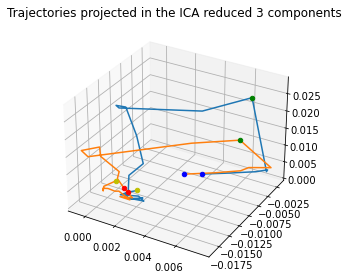

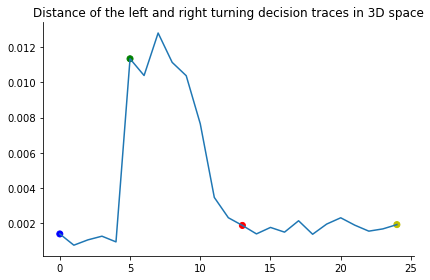

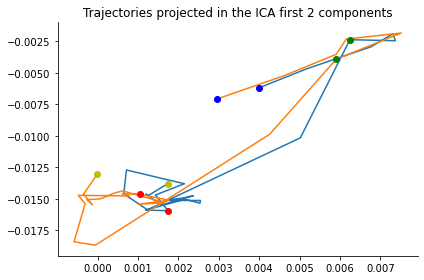

In [45]:
# plto 3D traces
# %matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(X_transformed_ica_left[:,0], X_transformed_ica_left[:,1], X_transformed_ica_left[:,2])
ax.plot(X_transformed_ica_right[:,0], X_transformed_ica_right[:,1], X_transformed_ica_right[:,2])

ax.scatter(X_transformed_ica_left[0,0], X_transformed_ica_left[0,1],X_transformed_ica_left[0,2], c='b')
ax.scatter(X_transformed_ica_right[0,0], X_transformed_ica_right[0,1],X_transformed_ica_right[0,2], c='b')

ax.scatter(X_transformed_ica_left[5,0], X_transformed_ica_left[5,1],X_transformed_ica_left[5,2], c='g')
ax.scatter(X_transformed_ica_right[5,0], X_transformed_ica_right[5,1],X_transformed_ica_right[5,2], c='g')

ax.scatter(X_transformed_ica_left[13,0], X_transformed_ica_left[13,1],X_transformed_ica_left[13,2], c='r')
ax.scatter(X_transformed_ica_right[13,0], X_transformed_ica_right[13,1],X_transformed_ica_right[13,2], c='r')

ax.scatter(X_transformed_ica_left[-1,0], X_transformed_ica_left[-1,1],X_transformed_ica_left[-1,2], c='y')
ax.scatter(X_transformed_ica_right[-1,0], X_transformed_ica_right[-1,1],X_transformed_ica_right[-1,2], c='y')
ax.set_title('Trajectories projected in the ICA reduced 3 components')


# plot the distance trace in the 3d space 
fig, ax = plt.subplots()
dists_3d = []
speeds_3d = []
for i in range(X_transformed_ica_left.shape[0]):
  dist = np.linalg.norm(X_transformed_ica_left[i]-X_transformed_ica_right[i], ord=2)
  dists_3d.append(dist)


plt.plot(dists_3d)
x_points = [0,5, 13, len(dists_3d)-1]
colors = ['b', 'g', 'r', 'y']
plt.scatter(x_points, np.array(dists_3d)[x_points], c=colors)
plt.title('Distance of the left and right turning decision traces in 3D space')

# for i in range(N_trials):
#   ax.plot(X_transformed_ica_viz[i,:,0], X_transformed_ica_viz[i,:,1], X_transformed_ica_viz[i,:,2])

# visualize 2D, in 1st and 2nd components
fig, ax = plt.subplots()
ax.plot(X_transformed_ica_left[:,0], X_transformed_ica_left[:,1])
ax.plot(X_transformed_ica_right[:,0], X_transformed_ica_right[:,1])

ax.plot(X_transformed_ica_left[0,0], X_transformed_ica_left[0,1], 'bo')
ax.plot(X_transformed_ica_right[0,0], X_transformed_ica_right[0,1], 'bo')

ax.plot(X_transformed_ica_left[51//binned_multiplier,0], X_transformed_ica_left[51//binned_multiplier,1], 'go')
ax.plot(X_transformed_ica_right[51//binned_multiplier,0], X_transformed_ica_right[51//binned_multiplier,1], 'go')

ax.plot(X_transformed_ica_left[131//binned_multiplier,0], X_transformed_ica_left[131//binned_multiplier,1], 'ro')
ax.plot(X_transformed_ica_right[131//binned_multiplier,0], X_transformed_ica_right[131//binned_multiplier,1], 'ro')

ax.plot(X_transformed_ica_left[-1,0], X_transformed_ica_left[-1,1], 'yo')
ax.plot(X_transformed_ica_right[-1,0], X_transformed_ica_right[-1,1], 'yo')
ax.set_title('Trajectories projected in the ICA first 2 components')


plt.tight_layout()
plt.show()

### viusalize the weights by brain regions

In [46]:


# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
# NN = len(dat['brain_area']) # number of neurons
# NN = len(select_inds)
# barea = nareas * np.ones(NN, ) # last one is "other"
# for j in range(nareas):
#   barea[np.isin(dat['brain_area'][select_inds], brain_groups[j])] = j # assign a number to each region



In [48]:
# sorted brain groups
brain_groups = [ ['VISrl', 'VISl', 'VISpm', 'VISp', 'VISa', 'VISam'],
['POL', 'MG', 'PT', 'LP', 'LGd', 'SPF', 'LD', 'PO', 'MD', 'VAL', 'VPL', 'VPM', 'TH','RT', 'CL', 'LH'],
['CA', 'CA2', 'CA3', 'POST', 'CA1', 'SUB', 'DG'],
['DP', 'COA', 'ILA', 'ORBm', 'RSP', 'OLF', 'PL', 'ACA', 'MOs', 'MOp', 'SSs', 'SSp','ORB', 'PIR', 'AUD', ' TT'],
['SCsg', 'NB', 'APN', 'PAG', 'SCs', 'SCig', 'MRN', 'IC', 'SCm', 'MB', 'RN', 'ZI'],
['LSc', 'LS', 'LSr', 'MS', 'ACB', 'GPe', 'OT', 'CP', 'SI', 'SNr'],
['BMA', 'EP', 'EPd', 'MEA', 'BLA'] ]



In [49]:
# plot weights by all brain regions 

big_region_len = np.zeros(len(brain_groups)+1)
for i, group in enumerate(brain_groups):
  big_region_len[i+1] = len(group) + big_region_len[i]

  
allareas = np.concatenate(brain_groups,axis=-1)
nareas = len(allareas) 
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], allareas[j])] = j # assign a number to each region


In [51]:


def plot_weights_by_brain_regions_across_sessions(dr_weights, allareas, sessions_areas, save_img_path=''):
  """
  dr_weights: List[np.ndarray] 
    [(n_neurons, n_comp)], n_sessions of dimension reduction weights to visualize
  allareas : np.ndarray
    (n_brain_areas,), names of all brain areas
  sessions_areas : np.ndarray
    [(n_neurons)], names of brain areas of all sessions

  """
  # get the brain regions of all sessions
  nareas = len(allareas) 
  n_sessions = len(sessions_areas) # number of sessions
  assert n_sessions == len(dr_weights), 'number of sessions needs to be equal'
  assert dr_weights[0].shape[0] == sessions_areas[0].shape[0], 'number of neurons per session needs to be equal'

  bareas = []
  for idx in range(n_sessions):
    NN = dr_weights[idx].shape[0]
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
      barea[np.isin(sessions_areas[idx], allareas[j])] = j # assign a number to each region
    bareas.append(barea)

  plt.figure(figsize=(30, 10))
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

  n_comp = dr_weights[0].shape[1]

  for comp in range(n_comp):
    ax = plt.subplot(n_comp,1,comp+1)
    for i in range(nareas):
      # set colors
      c_idx = np.where(big_region_len[1:]-i > 0)[0][0]
      cur_color = colors[c_idx]
      # select weights according to brain region
      weight_selected = np.array([])
      for idx in range(n_sessions):
        weight_selected = np.append(weight_selected, dr_weights[idx][bareas[idx]==i,comp])
      bars = ax.bar(i, np.mean(np.abs(weight_selected)), color=[cur_color])
    
    ax.set(xlabel = 'Region', ylabel = 'Weight', title = f'Mean Weights Per Region of Component {comp}')
    plt.xticks(np.arange(nareas), allareas, rotation='vertical')
  if save_img_path != '':
    plt.savefig(f'figs/{save_img_path}')


# plot_weights_by_brain_regions_across_sessions([W_ica.T], allareas, [dat['brain_area']])


def plot_weights_by_big_brain_regions_across_sessions(dr_weights, brain_groups, sessions_areas, save_img_path=''):
  """
  dr_weights: List[np.ndarray] 
    [(n_neurons, n_comp)], n_sessions of dimension reduction weights to visualize
  allareas : np.ndarray
    (n_brain_areas,), names of all brain areas
  sessions_areas : np.ndarray
    [(n_neurons)], names of brain areas of all sessions

  """
  # get the brain regions of all sessions
  nareas = len(brain_groups) 
  n_sessions = len(sessions_areas) # number of sessions
  assert n_sessions == len(dr_weights), 'number of sessions needs to be equal'
  assert dr_weights[0].shape[0] == sessions_areas[0].shape[0], 'number of neurons per session needs to be equal'

  bareas = []
  for idx in range(n_sessions):
    NN = dr_weights[idx].shape[0]
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
      barea[np.isin(sessions_areas[idx], brain_groups[j])] = j # assign a number to each region
    bareas.append(barea)

  plt.figure(figsize=(20, 7))
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

  n_comp = dr_weights[0].shape[1]

  for comp in range(n_comp):
    ax = plt.subplot(1, n_comp,comp+1)
    for i in range(nareas):
      # select weights according to brain region
      weight_selected = np.array([])
      for idx in range(n_sessions):
        weight_selected = np.append(weight_selected, dr_weights[idx][bareas[idx]==i,comp])
      bars = ax.bar(i, np.mean(np.abs(weight_selected)),color=[colors[i]])
    
    ax.set(xlabel = 'Region', ylabel = 'Weight', title = f'Mean Weights Per Region of Component {comp}')
    group_names = ['visual cortex', 'thalamus', 'hippocampal', 'non-visual cortex', 'midbrain', 'basal ganglia', 'cortical subplate']
    plt.xticks(np.arange(nareas), group_names, rotation='vertical')
  if save_img_path != '':
    plt.savefig(f'figs/{save_img_path}')

# plot_weights_by_big_brain_regions_across_sessions([W_ica.T], brain_groups, [dat['brain_area'][select_inds]])


### Visualize across all brain regions and all sessions

In [52]:
# get session data

weights = []
sessions_areas = []
for i, dat in enumerate(alldat):
  # prepare data
  all_spikes = dat['spks']
  NN = all_spikes.shape[0]
  N_trials = all_spikes.shape[1]
  # time bins of 100ms 
  binned_multiplier = 10
  all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
  all_spikes = np.sum(all_spikes_bined, axis=-1)
  # get the period between stimulus and go cue
  stim_onset = 51 //binned_multiplier
  max_len = (int(np.ceil(100*np.max(dat['gocue']))) + stim_onset)//binned_multiplier
  data = np.reshape(all_spikes[:,:,stim_onset:stim_onset+max_len], (NN, -1)).T 
  # get rid of inactive neurons
  select_inds = get_rid_of_inactive_neurons(all_spikes[:,:,stim_onset:stim_onset+max_len])
  data = data[:,select_inds]

  sessions_areas.append(dat['brain_area'][select_inds])
  # run ICA and get weights
  ica_comp = 3
  transformer = FastICA(n_components=ica_comp, random_state=0)
  ica_model = transformer.fit(data)
  W_ica = ica_model.components_
  weights.append(W_ica.T)
  print(f'finished session {i}')
  

finished session 0
finished session 1
finished session 2


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 9
finished session 10
finished session 11
finished session 12
finished session 13
finished session 14
finished session 15
finished session 16
finished session 17
finished session 18
finished session 19
finished session 20
finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31
finished session 32
finished session 33
finished session 34
finished session 35
finished session 36
finished session 37
finished session 38


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


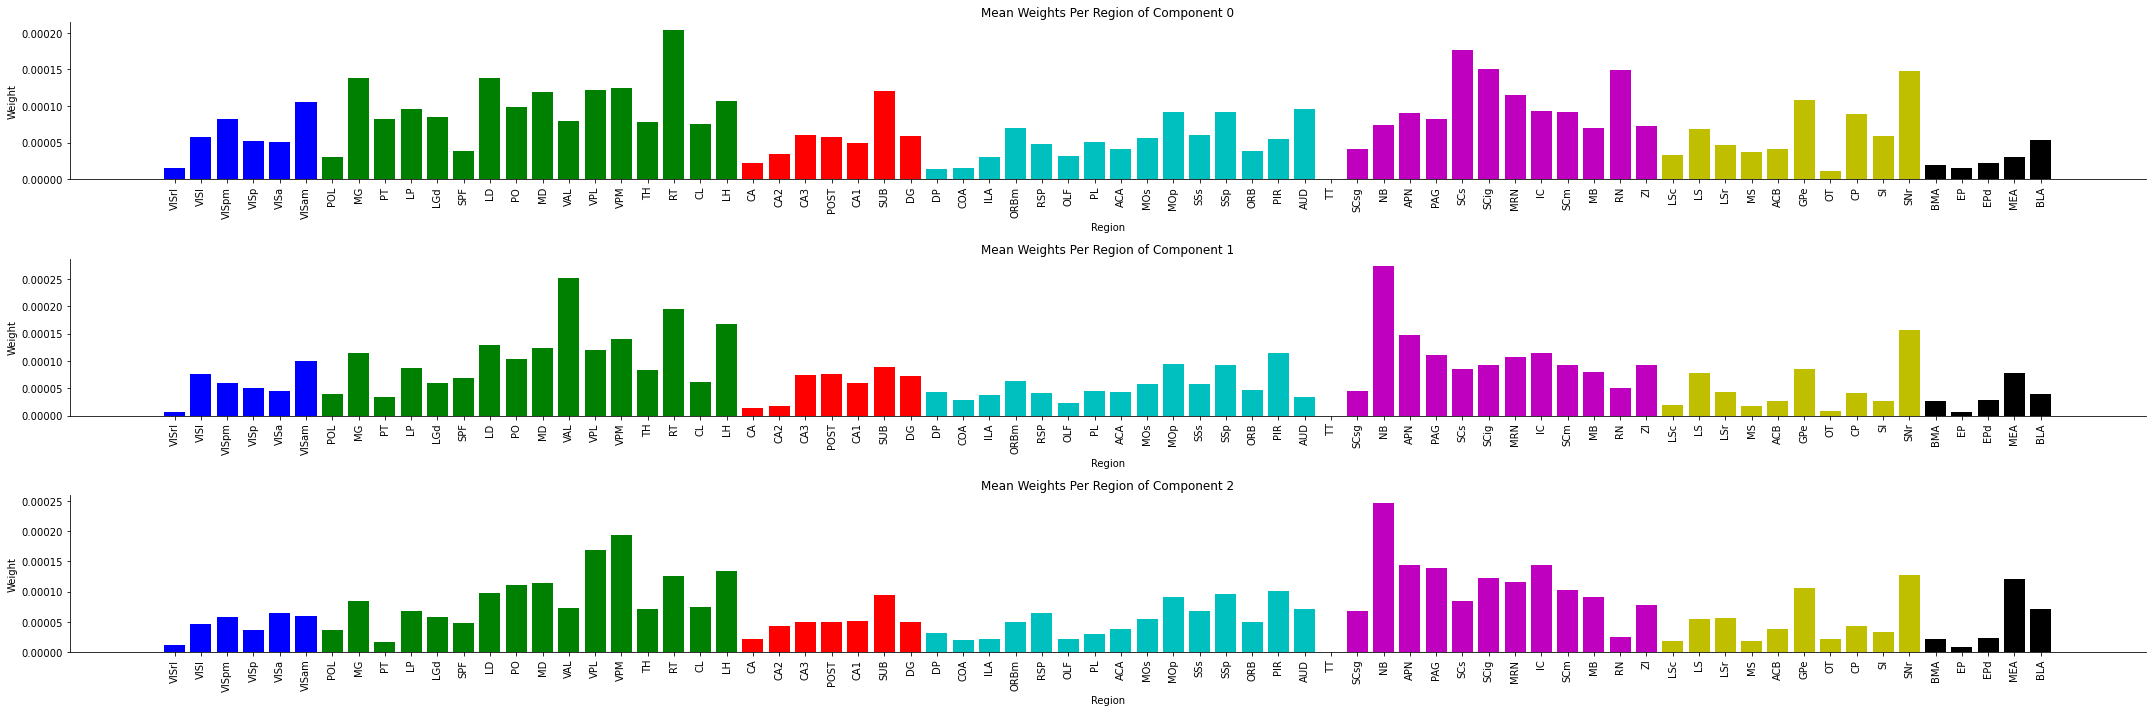

In [53]:
# plot weights
plot_weights_by_brain_regions_across_sessions(weights, allareas, sessions_areas, 'ICA_all_ses.png')


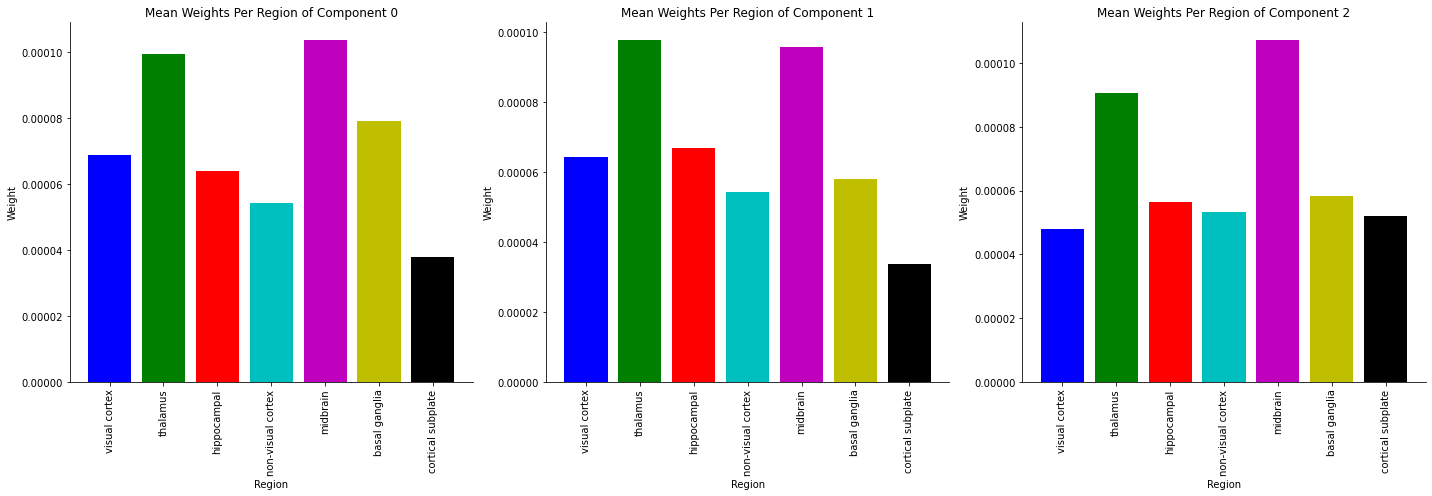

In [54]:


# plot weights

plot_weights_by_big_brain_regions_across_sessions(weights, brain_groups, sessions_areas, 'ICA_big_regions.png')



In [55]:
# TRY PLOTTING PCA
# get session data

from sklearn.decomposition import PCA 


PCA_weights = []
sessions_areas = []
for i, dat in enumerate(alldat):
  # prepare data
  all_spikes = dat['spks']
  NN = all_spikes.shape[0]
  N_trials = all_spikes.shape[1]
  # time bins of 100ms 
  binned_multiplier = 10
  all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
  all_spikes = np.sum(all_spikes_bined, axis=-1)
  # get the period between stimulus and go cue
  stim_onset = 51 //binned_multiplier
  max_len = (int(np.ceil(100*np.max(dat['gocue']))) )//binned_multiplier
  data = np.reshape(all_spikes[:,:,stim_onset:stim_onset+max_len], (NN, -1)).T 
  # get rid of inactive neurons
  select_inds = get_rid_of_inactive_neurons(all_spikes[:,:,stim_onset:stim_onset+max_len])
  data = data[:,select_inds]

  sessions_areas.append(dat['brain_area'][select_inds])
  # run PCA and get weights
  n_PC_components = 3
  pca_model = PCA(n_components = n_PC_components).fit(data) # run PCA using stim period 
  W_pca = pca_model.components_
  PCA_weights.append(W_pca.T)
  print(f'finished session {i}')

# plot weights
plot_weights_by_brain_regions_across_sessions(PCA_weights, allareas, sessions_areas, 'PCA_all_ses.png')

finished session 0
finished session 1
finished session 2
finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8
finished session 9
finished session 10
finished session 11
finished session 12
finished session 13
finished session 14
finished session 15
finished session 16
finished session 17
finished session 18
finished session 19
finished session 20
finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31
finished session 32
finished session 33
finished session 34
finished session 35
finished session 36
finished session 37
finished session 38


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


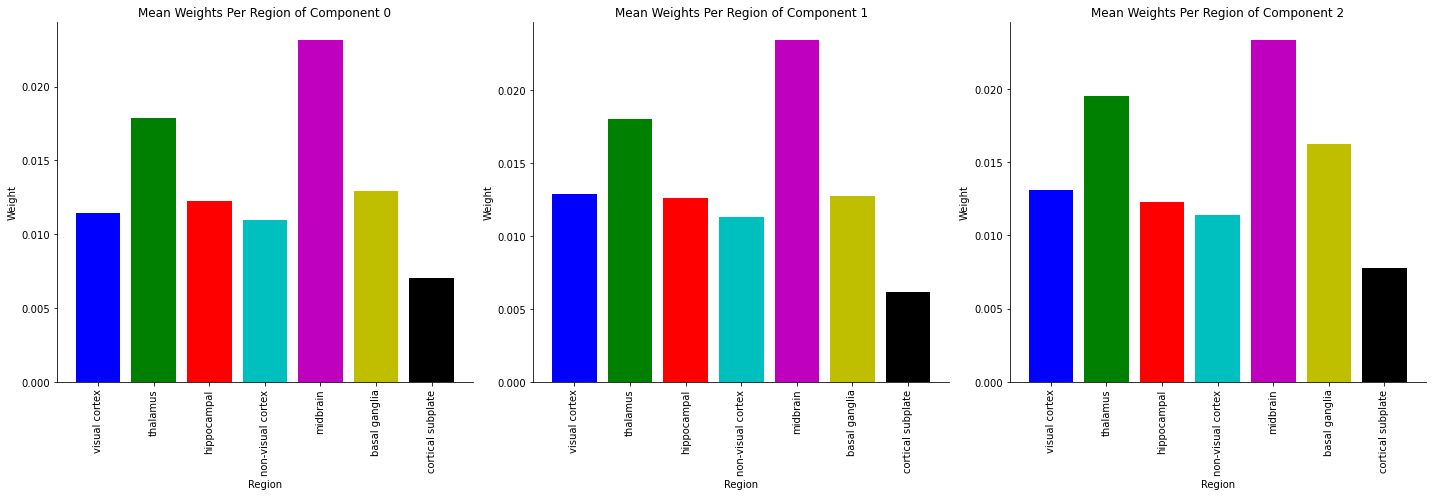

In [56]:

plot_weights_by_big_brain_regions_across_sessions(PCA_weights, brain_groups, sessions_areas, 'PCA_big_regions.png')



## Naive Bayes Classifier

In [62]:
# use Bernoulli naive bayes to classify 

from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()


# X = X_transformed.reshape((N_trials, -1))[idxs]

# nb_clf.fit(X, Y)


## Logistic Regression Classifier

In [64]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=0)

X_transformed_ica = ica_transformer.fit_transform(data)
print(X_transformed_ica.shape)

X = X_transformed_ica.reshape((N_trials, -1))[idxs]
lr_clf.fit(X, Y)



(2744, 3)


LogisticRegression(random_state=0)

## Cross-validation and evaluation

In [65]:
from sklearn.model_selection import cross_validate 




In [66]:

scores = cross_validate(lr_clf, X, Y, cv=3, return_train_score=True)

print(scores)
score = np.mean(scores['test_score'])
print(score)


{'fit_time': array([0.00528026, 0.00404906, 0.00259805]), 'score_time': array([0.00057888, 0.00024676, 0.00035453]), 'test_score': array([0.51086957, 0.51086957, 0.51086957]), 'train_score': array([0.51086957, 0.51086957, 0.51086957])}
0.5108695652173914


### Find the optimal number of reduced components

In [68]:
# find the optimal number of reduced components

components = [3, 6, 10, 15, 20, 100, 150]
cv = 3



all_scores = []
for comp in components:

  ses_scores = []
  for i, dat in enumerate(alldat):
    # prepare data
    all_spikes = dat['spks']
    NN = all_spikes.shape[0]
    N_trials = all_spikes.shape[1]
    # time bins of 100ms 
    binned_multiplier = 10
    all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
    all_spikes = np.sum(all_spikes_bined, axis=-1)
    # get the period between stimulus and go cue
    stim_onset = 51 //binned_multiplier
    max_len = (int(np.ceil(100*np.max(dat['gocue']))) )//binned_multiplier
    data = np.reshape(all_spikes[:,:,stim_onset:stim_onset+max_len], (NN, -1)).T 
    # print('all_spikes: ', all_spikes.shape)
    # get rid of inactive neurons
    select_inds = get_rid_of_inactive_neurons(all_spikes[:,:,stim_onset:stim_onset+max_len])
    
    data = data[:,select_inds]

    transformer = FastICA(n_components=comp, random_state=0)
    X_transformed = transformer.fit_transform(data)

    # get the left and right trials indices
    choice_responses = dat['response']
    # print('left trials: ', len(np.where(choice_responses < 0)[0]))
    # print('right trials: ', len(np.where(choice_responses > 0)[0]))
    idxs_left = np.where(choice_responses < 0)[0]
    idxs_right = np.where(choice_responses > 0)[0]
    idxs = np.append(idxs_left, idxs_right)
    Y = choice_responses[idxs]
    X = X_transformed.reshape((N_trials, -1))[idxs]
    # cross validate
    scores = cross_validate(lr_clf, X, Y, cv=cv)
    score = np.mean(scores['test_score'])
    ses_scores.append(score)

    print(f'finished session {i}')
  all_scores.append(ses_scores)

  print(f'finished eval comp {comp}\n')


finished session 0
finished session 1
finished session 2


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 9
finished session 10
finished session 11
finished session 12
finished session 13
finished session 14
finished session 15
finished session 16
finished session 17
finished session 18
finished session 19
finished session 20
finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31
finished session 32
finished session 33
finished session 34
finished session 35
finished session 36
finished session 37
finished session 38
finished eval comp 3

finished session 0
finished session 1
finished session 2


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 9
finished session 10
finished session 11
finished session 12
finished session 13
finished session 14


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 15
finished session 16
finished session 17
finished session 18


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 19
finished session 20


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31
finished session 32
finished session 33
finished session 34
finished session 35
finished session 36
finished session 37


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 38
finished eval comp 6

finished session 0
finished session 1
finished session 2
finished session 3
finished session 4
finished session 5


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 6
finished session 7
finished session 8


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 9
finished session 10
finished session 11
finished session 12


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 13
finished session 14
finished session 15
finished session 16
finished session 17
finished session 18
finished session 19
finished session 20


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 32
finished session 33
finished session 34


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 35


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 36
finished session 37


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 38
finished eval comp 10

finished session 0
finished session 1
finished session 2
finished session 3
finished session 4
finished session 5


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 6
finished session 7
finished session 8
finished session 9
finished session 10
finished session 11
finished session 12
finished session 13


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 14


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 15


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 16


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 17
finished session 18
finished session 19
finished session 20


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 21
finished session 22
finished session 23


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31
finished session 32
finished session 33
finished session 34


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 35
finished session 36
finished session 37
finished session 38
finished eval comp 15

finished session 0
finished session 1
finished session 2
finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8
finished session 9
finished session 10


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 11


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 12


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 13


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 14
finished session 15


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 16


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 17


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 18
finished session 19
finished session 20
finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 28
finished session 29
finished session 30
finished session 31
finished session 32


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 33
finished session 34
finished session 35
finished session 36
finished session 37
finished session 38
finished eval comp 20



/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 0
finished session 1
finished session 2
finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8
finished session 9
finished session 10


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 11


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 12
finished session 13
finished session 14
finished session 15


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 16
finished session 17


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 18
finished session 19
finished session 20


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 21
finished session 22


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 23


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 24
finished session 25
finished session 26


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 27
finished session 28
finished session 29
finished session 30


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 31


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 32


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 33


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 34


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 35
finished session 36
finished session 37
finished session 38
finished eval comp 100



/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 0
finished session 1


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 2
finished session 3
finished session 4
finished session 5
finished session 6
finished session 7
finished session 8


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 9
finished session 10


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 11


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 12


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 13


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 14


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 15
finished session 16
finished session 17


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 18


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 19
finished session 20
finished session 21
finished session 22


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 23


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 24
finished session 25


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 26
finished session 27


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 28
finished session 29


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 30


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 31
finished session 32
finished session 33


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 34


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 35


/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 36
finished session 37
finished session 38
finished eval comp 150



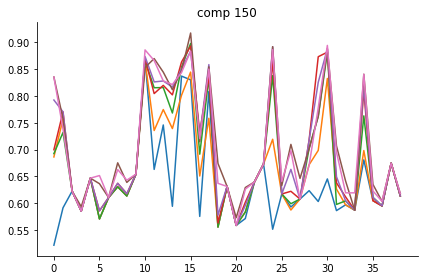

In [69]:

# plot scores per comp 

for i, comp_scores in enumerate(all_scores):
  # plt.figure()
  plt.plot(comp_scores)
  plt.title(f'comp {components[i]}')


### NB classifier for ICA

In [70]:
# find the optimal number of reduced components

from sklearn.decomposition import FastICA
from sklearn.model_selection import cross_validate 



components = [3]
cv = 3
half_time_win = 20


for comp in components:

    
    all_go_scores = []
    # all_correct_scores = []
    all_right_stim_scores = []
    
    for brain_region_i in range(5):
        go_scores = []
        # correct_scores = []
        right_stim_scores = []
        
        for i, dat in enumerate(alldat):
            # prepare data

            # get the visual stimulus slice
            # all_spikes = dat['spks'][:,:,50-half_time_wind:50+half_time_wind]      

            # get the gocue slice
            # all_spikes = get_gocue_slice(dat, half_time_win)

            all_spikes = dat['spks']
            if np.sum(neurons_for_decoding[i, brain_region_i]) == 0:
                # correct_scores.append(-1)
                go_scores.append(-1)
                right_stim_scores.append(-1)
                continue
                
            all_spikes = all_spikes[neurons_for_decoding[i, brain_region_i].astype('bool')]

            NN = all_spikes.shape[0]
            N_trials = all_spikes.shape[1]
            N_time_bins = all_spikes.shape[2]

            # # time bins of 100ms 
            # binned_multiplier = 10
            # all_spikes_bined = all_spikes.reshape(NN, N_trials, -1, binned_multiplier)
            # all_spikes = np.sum(all_spikes_bined, axis=-1)

            # # get the period between stimulus and go cue
            # stim_onset = 51 //binned_multiplier
            # max_len = (int(np.ceil(100*np.max(dat['gocue']))) )//binned_multiplier
            # data = np.reshape(all_spikes[:,:,stim_onset:stim_onset+max_len], (NN, -1)).T 
            # print('all_spikes: ', all_spikes.shape)

            data = np.reshape(all_spikes, (NN, -1)).T 

            # # get rid of inactive neurons
            # select_inds = get_rid_of_inactive_neurons(all_spikes)
            # data = data[:,select_inds]

            transformer = FastICA(n_components=comp, random_state=0)
            X_transformed = transformer.fit_transform(data)

            # get the left and right trials indices
            choice_responses = dat['response']
            # print('left trials: ', len(np.where(choice_responses < 0)[0]))
            # print('right trials: ', len(np.where(choice_responses > 0)[0]))
            # idxs_left = np.where(choice_responses < 0)[0]
            # idxs_right = np.where(choice_responses > 0)[0]
            # idxs = np.append(idxs_left, idxs_right)
            # Y = choice_responses[idxs]

            
            # get the gocue slice
            X_transformed = X_transformed.reshape((N_trials, N_time_bins, -1)) 
            X = get_gocue_slice_for_x(dat, X_transformed, half_time_win)
            X = X.reshape((N_trials, -1))
        
            # go/no go 
            Y = (choice_responses == 0)
            # X = X_transformed.reshape((N_trials, -1))        
            # X = X_transformed.reshape((N_trials, -1))[idxs]

            # cross validate
            scores = cross_validate(nb_clf, X, Y, cv=cv)
            score = np.mean(scores['test_score'])
            
            go_scores.append(score)

            # reward 
            # Y = dat['feedback_type']
            
            # get the vis stimulus slice
            X = X_transformed[:,50-half_time_wind:50+half_time_wind]
            X = X.reshape((N_trials, -1))
            
            # right contrast vs no contrast
            Y = dat['contrast_right'] == 0
            
            # cross validate
            scores = cross_validate(nb_clf, X, Y, cv=cv)
            score = np.mean(scores['test_score'])
            
            # correct_scores.append(score)
            right_stim_scores.append(score)


            print(f'finished session {i}')
            
        
        all_go_scores.append(go_scores)
        # all_correct_scores.append(correct_scores)
        all_right_stim_scores.append(right_stim_scores)
        print(f'finished brain region  {brain_region_i}\n')

    print(f'finished eval comp {comp}\n')
# HIDE CELL

finished session 0
finished session 1
finished session 2
finished session 3
finished session 4
finished session 7
finished session 8
finished session 9
finished session 11
finished session 12
finished session 13
finished session 18
finished session 19
finished session 21
finished session 22
finished session 23
finished session 24
finished session 25
finished session 26
finished session 27
finished session 34
finished session 35
finished session 36
finished session 38
finished brain region  0

finished session 2
finished session 3
finished session 5
finished session 6
finished session 7
finished session 8
finished session 9
finished session 10
finished session 11
finished session 12
finished session 14
finished session 15
finished session 16
finished session 17
finished session 18
finished session 19
finished session 20
finished session 22
finished session 26
finished session 27
finished session 29
finished session 30
finished session 32
finished session 33
finished session 34
finished 

/home/m/anaconda3/envs/dj/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


finished session 13
finished session 14
finished session 15
finished session 17
finished session 18
finished session 21
finished session 23
finished session 24
finished session 25
finished session 27
finished session 30
finished session 31
finished session 32
finished session 33
finished session 35
finished session 36
finished brain region  4

finished eval comp 3



In [73]:

for i in range(len(components)): 
    print('comp: ', components[i])
    
    print('go/no go: ', sum(all_go_scores[i])/len(all_go_scores[i]))

    print('min: ', min(all_go_scores[i]))
    print('max: ', max(all_go_scores[i]))
    print(all_go_scores[i])


#     print('reward: ', sum(all_correct_scores[i])/len(all_correct_scores[i]))

#     print('min: ', min(all_correct_scores[i]))
#     print('max: ', max(all_correct_scores[i]))
#     print(all_correct_scores[i])
    print()
    

comp:  3
go/no go:  0.03614671860432727
min:  -1
max:  0.7878080657206871
[0.6170448617631715, 0.7247083572384776, 0.6447368421052632, 0.7349397590361445, 0.7320728291316527, -1, -1, 0.6798144960795564, 0.728494623655914, 0.7360178970917226, -1, 0.7707395331987786, 0.73, 0.6718268830628382, -1, -1, -1, -1, 0.5669507297482613, 0.578708211619604, -1, 0.7004504504504504, 0.7809150326797386, 0.6308243727598567, 0.6896551724137931, 0.7133709981167607, 0.7626050420168067, 0.5978132387706856, -1, -1, -1, -1, -1, -1, 0.7878080657206871, 0.6821705426356589, 0.5355191256830601, -1, 0.6125349605898806]



In [74]:

for i in range(5): 
    print('brain_region: ', regions[i])
    
    print('go/no go: ', sum(all_go_scores[i])/len(all_go_scores[i]))

    print('min: ', min(all_go_scores[i]))
    print('max: ', max(all_go_scores[i]))
    print()
    print(all_go_scores[i])
    print()

    print('right contrast: ', sum(all_right_stim_scores[i])/len(all_right_stim_scores[i]))

    print('min: ', min(all_right_stim_scores[i]))
    print('max: ', max(all_right_stim_scores[i]))
    print()
    print(all_right_stim_scores[i])
    print()
    



brain_region:  vis ctx
go/no go:  0.03614671860432727
min:  -1
max:  0.7878080657206871

[0.6170448617631715, 0.7247083572384776, 0.6447368421052632, 0.7349397590361445, 0.7320728291316527, -1, -1, 0.6798144960795564, 0.728494623655914, 0.7360178970917226, -1, 0.7707395331987786, 0.73, 0.6718268830628382, -1, -1, -1, -1, 0.5669507297482613, 0.578708211619604, -1, 0.7004504504504504, 0.7809150326797386, 0.6308243727598567, 0.6896551724137931, 0.7133709981167607, 0.7626050420168067, 0.5978132387706856, -1, -1, -1, -1, -1, -1, 0.7878080657206871, 0.6821705426356589, 0.5355191256830601, -1, 0.6125349605898806]

right contrast:  0.05227650543160866
min:  -1
max:  0.938135593220339

[0.5232785602503912, 0.8965385350927519, 0.6403508771929824, 0.5060240963855421, 0.6258636788048553, -1, -1, 0.7641518454771467, 0.8413978494623656, 0.5950782997762863, -1, 0.8941158205247633, 0.6133333333333333, 0.5039117769454847, -1, -1, -1, -1, 0.7044274659614066, 0.8254354646759711, -1, 0.8783783783783784, 0

### decoder on vis and gocue slices

brain_region:  vis ctx
go/no go:  0.0021647542950417866
min:  -1
max:  0.7523960667164551

[0.6636019822639541, 0.5656435264869, 0.6578947368421052, 0.48995983935742976, 0.5867413632119515, -1, -1, 0.6438611589214, 0.6048387096774194, 0.6599552572706936, -1, 0.7472700926357191, 0.7000000000000001, 0.7424469413233458, -1, -1, -1, -1, 0.4981388970516211, 0.5022178946229579, -1, 0.7274774774774775, 0.5827450980392157, 0.5238095238095238, 0.7011494252873564, 0.724764595103578, 0.6169000933706816, 0.5492021276595745, -1, -1, -1, -1, -1, -1, 0.7523960667164551, 0.6085271317829457, 0.6577413479052824, -1, 0.5771421306890415]

right contrast:  -0.04798117919556956
min:  -1
max:  0.6463570127504553

[0.6024387063119457, 0.525865366226812, 0.5, 0.5582329317269076, 0.6338001867413632, -1, -1, 0.5279690189328744, 0.5725806451612904, 0.4697986577181208, -1, 0.4795062878435026, 0.47, 0.5038285476487724, -1, -1, -1, -1, 0.5181702419433832, 0.549226441631505, -1, 0.5518018018018017, 0.5363398692810458, 0.6041986687147977, 0.521072796934866, 0.528436911487759, 0.6090102707749767, 0.605644208037825, -1, -1, -1, -1, -1, -1, 0.5498506348020912, 0.4728682170542636, 0.6463570127504553, -1, 0.5917365878464277]

brain_region:  thal
go/no go:  0.1382416044589164
min:  -1
max:  0.7649714391007922

[-1, -1, 0.6447368421052632, 0.48995983935742976, -1, 0.6034149484536083, 0.6825396825396824, 0.6438611589214, 0.6129032258064516, 0.6666666666666666, 0.6842105263157894, 0.7472700926357191, 0.75, -1, 0.7649714391007922, 0.7143292915427439, 0.758978978978979, 0.7122791254866726, 0.5260064648839259, 0.5150384074434707, 0.4678668215253581, -1, 0.576078431372549, -1, -1, -1, 0.6208683473389356, 0.5492021276595745, -1, 0.6854314420803783, 0.6666666666666666, -1, 0.7590112433862434, 0.5676149247577819, 0.74592357480707, -1, -1, 0.6584501733755466, 0.5771421306890415]

right contrast:  0.06703610610334919
min:  -1
max:  0.7309941520467836

[-1, -1, 0.47807017543859653, 0.5582329317269076, -1, 0.5067654639175257, 0.45634920634920634, 0.5279690189328744, 0.5672043010752689, 0.47427293064876963, 0.7309941520467836, 0.4795062878435026, 0.48, -1, 0.4926478717523493, 0.5001906504995043, 0.611891891891892, 0.5347109913147648, 0.48187873444999507, 0.6171697500811425, 0.4839334107626791, -1, 0.5363398692810458, -1, -1, -1, 0.6050420168067228, 0.605644208037825, -1, 0.5391548463356974, 0.5569620253164557, -1, 0.5755621693121693, 0.594791451934309, 0.5498506348020912, -1, -1, 0.47753655962611186, 0.5917365878464277]

brain_region:  hipp
go/no go:  0.08109187188520664
min:  -1
max:  0.7966666666666667

[0.6636019822639541, 0.5656435264869, 0.6578947368421052, 0.48192771084337344, 0.6025210084033614, 0.6034149484536083, 0.6507936507936508, 0.6438611589214, 0.6048387096774194, 0.6666666666666666, -1, 0.7472700926357191, 0.7966666666666667, 0.7424469413233458, -1, -1, -1, 0.7028451632225217, 0.5219414242335194, 0.5150384074434707, -1, -1, 0.5963398692810458, 0.5238095238095238, -1, -1, 0.5378151260504201, 0.5492021276595745, -1, 0.6854314420803783, 0.5189873417721519, -1, -1, -1, 0.7587752053771472, 0.6007751937984497, -1, 0.6584501733755466, 0.5656242054411391]

right contrast:  0.024194456289292295
min:  -1
max:  0.6171697500811425

[0.6024387063119457, 0.525865366226812, 0.5, 0.5742971887550201, 0.6099906629318393, 0.5067654639175257, 0.4365079365079365, 0.5279690189328744, 0.5725806451612904, 0.47427293064876963, -1, 0.4795062878435026, 0.48333333333333334, 0.5038285476487724, -1, -1, -1, 0.5378556454028152, 0.49794299147810756, 0.6171697500811425, -1, -1, 0.5296732026143791, 0.6041986687147977, -1, -1, 0.6089635854341736, 0.605644208037825, -1, 0.5391548463356974, 0.5527426160337553, -1, -1, -1, 0.5594971371670401, 0.4573643410852713, -1, 0.4472335293230816, 0.5887871853546911]

brain_region:  other ctx
go/no go:  0.17560676094386657
min:  -1
max:  0.7523960667164551

[0.6588419405320813, -1, -1, 0.48995983935742976, 0.5592903828197946, 0.64465206185567, 0.6507936507936508, 0.6479250334672022, 0.6048387096774194, -1, 0.6842105263157894, 0.7472700926357191, 0.7433333333333333, 0.7424469413233458, -1, 0.728628079005567, -1, -1, -1, -1, 0.4283778552071235, 0.7297297297297298, -1, 0.5238095238095238, 0.7126436781609197, 0.724764595103578, 0.5339402427637722, 0.5492021276595745, 0.6954595791805094, 0.6854314420803783, 0.5105485232067511, 0.6921946003742314, -1, 0.5742458599601457, 0.7523960667164551, 0.5930232558139535, 0.6577413479052824, -1, 0.5829646580218664]

right contrast:  0.1155316072419932
min:  -1
max:  0.7309941520467836

[0.5886802295253001, -1, -1, 0.5582329317269076, 0.6258636788048553, 0.517110538373425, 0.4365079365079365, 0.48412698412698413, 0.5725806451612904, -1, 0.7309941520467836, 0.4795062878435026, 0.4766666666666666, 0.5038285476487724, -1, 0.5001906504995043, -1, -1, -1, -1, 0.516066589237321, 0.545045045045045, -1, 0.6041986687147977, 0.521072796934866, 0.5395480225988701, 0.6010270774976657, 0.605644208037825, 0.5861941675895164, 0.5391548463356974, 0.5611814345991561, 0.5500757373251358, -1, 0.6014223871366728, 0.5498506348020912, 0.4728682170542635, 0.6463570127504553, -1, 0.5917365878464277]

brain_region:  midbrain
go/no go:  -0.1896369093108338
min:  -1
max:  0.7792792792792792

[-1, -1, 0.6447368421052632, -1, -1, -1, -1, -1, -1, 0.6554809843400448, -1, -1, 0.75, 0.7424469413233458, 0.7649714391007922, 0.7143292915427439, -1, 0.7122791254866726, 0.5260064648839259, -1, -1, 0.7792792792792792, -1, 0.5238095238095238, 0.7011494252873564, 0.724764595103578, -1, 0.5492021276595745, -1, -1, 0.5189873417721519, 0.7115744453354718, 0.7590112433862434, 0.5676149247577819, -1, 0.6007751937984497, 0.6577413479052824, -1, -1]

right contrast:  -0.25312416463093856
min:  -1
max:  0.6463570127504553

[-1, -1, 0.4868421052631579, -1, -1, -1, -1, -1, -1, 0.4697986577181208, -1, -1, 0.48, 0.5038285476487724, 0.4926478717523493, 0.5001906504995043, -1, 0.5347109913147648, 0.48187873444999507, -1, -1, 0.5270270270270271, -1, 0.6041986687147977, 0.5172413793103449, 0.5395480225988701, -1, 0.605644208037825, -1, -1, 0.5527426160337553, 0.557783123941905, 0.5755621693121693, 0.594791451934309, -1, 0.4573643410852713, 0.6463570127504553, -1, -1]


### trained on entire dataset for each of the brain regions

brain_region:  vis ctx
go/no go:  0.021368611211360553
min:  -1
max:  0.8445945945945946

[0.6778169014084506, 0.6211990820424554, 0.6403508771929824, 0.5502008032128515, 0.7402427637721756, -1, -1, 0.7800248613501625, 0.6854838709677419, 0.6442953020134228, -1, 0.7181597060497853, 0.7766666666666667, 0.7387016229712859, -1, -1, -1, -1, 0.6960525026937017, 0.5529049010061668, -1, 0.8445945945945946, 0.6430065359477125, 0.5184331797235023, 0.7241379310344828, 0.6580037664783428, 0.6172735760971054, 0.492612293144208, -1, -1, -1, -1, -1, -1, 0.7171085387104804, 0.6472868217054263, 0.46948998178506374, -1, 0.6793287566742944]

reward:  0.008042341325400706
min:  -1
max:  0.7234901412824096

[0.6919014084507041, 0.5935169248422261, 0.5789473684210527, 0.570281124497992, 0.6300186741363212, -1, -1, 0.6280837636259323, 0.6263440860215054, 0.6263982102908278, -1, 0.7234901412824096, 0.7200000000000001, 0.6716604244694132, -1, -1, -1, -1, 0.6074542070721912, 0.5699448231093801, -1, 0.6554054054054054, 0.7023529411764707, 0.5884963304318144, 0.6743295019157088, 0.64105461393597, 0.54593837535014, 0.5985520094562647, -1, -1, -1, -1, -1, -1, 0.6945481702763256, 0.6627906976744186, 0.6911657559198542, -1, 0.620976353928299]

brain_region:  thal
go/no go:  0.164976393176529
min:  -1
max:  0.8206615120274914

[-1, -1, 0.6842105263157895, 0.5461847389558233, -1, 0.8206615120274914, 0.6349206349206349, 0.7800248613501625, 0.6801075268817204, 0.6442953020134228, 0.6871345029239766, 0.7122600010350361, 0.7766666666666667, -1, 0.722811866592961, 0.6607565011820331, 0.7411411411411412, 0.7090745732255166, 0.6878734449995102, 0.5529049010061668, 0.7259001161440185, -1, 0.6430065359477125, -1, -1, -1, 0.6133520074696545, 0.492612293144208, -1, 0.79048463356974, 0.7130801687763713, -1, 0.800760582010582, 0.5709132137703565, 0.7203136669156086, -1, -1, 0.6432986582240313, 0.6793287566742944]

reward:  0.14889392714776625
min:  -1
max:  0.7855255255255255

[-1, -1, 0.6008771929824561, 0.5622489959839357, -1, 0.7720861970217641, 0.623015873015873, 0.6280837636259323, 0.6397849462365591, 0.6263982102908278, 0.7251461988304092, 0.7029705532267246, 0.7200000000000001, -1, 0.717689331122167, 0.7181041714329292, 0.7855255255255255, 0.7533692722371969, 0.6034381428151631, 0.5699448231093801, 0.5723964382500969, -1, 0.7023529411764707, -1, -1, -1, 0.545891690009337, 0.5985520094562647, -1, 0.6926713947990543, 0.6877637130801687, -1, 0.7275132275132276, 0.5540094825809111, 0.6977532984814538, -1, -1, 0.6582994120307553, 0.620976353928299]

brain_region:  hipp
go/no go:  0.11040253470043616
min:  -1
max:  0.8206615120274914

[0.6778169014084506, 0.6171830177854275, 0.6842105263157895, 0.5502008032128515, 0.7402894491129786, 0.8206615120274914, 0.6547619047619048, 0.7800248613501625, 0.6854838709677419, 0.6554809843400448, -1, 0.7122600010350361, 0.7366666666666667, 0.7387016229712859, -1, -1, -1, 0.49029649595687336, 0.69610147908708, 0.557232500270475, -1, -1, 0.6430065359477125, 0.5294418842805939, -1, -1, 0.6133520074696545, 0.492612293144208, -1, 0.7974290780141843, 0.7299578059071731, -1, -1, -1, 0.7171085387104804, 0.6627906976744186, -1, 0.6432986582240313, 0.6793287566742944]

reward:  0.09189649394935336
min:  -1
max:  0.7720861970217641

[0.6919014084507041, 0.589500860585198, 0.6008771929824561, 0.570281124497992, 0.6144257703081233, 0.7720861970217641, 0.6111111111111112, 0.6320998278829604, 0.6263440860215054, 0.6308724832214765, -1, 0.7029705532267246, 0.6733333333333333, 0.6716604244694132, -1, -1, -1, 0.6902964959568734, 0.5953080615143501, 0.5530130909877745, -1, -1, 0.7023529411764707, 0.6095750128008192, -1, -1, 0.545891690009337, 0.5985520094562647, -1, 0.6926713947990543, 0.6160337552742616, -1, -1, -1, 0.6945481702763256, 0.624031007751938, -1, 0.6532489069802502, 0.620976353928299]

brain_region:  other ctx
go/no go:  0.2118023582778668
min:  -1
max:  0.8671171171171173

[0.677621283255086, -1, -1, 0.5502008032128515, 0.7402894491129786, 0.8206615120274914, 0.6547619047619048, 0.7720883534136546, 0.6854838709677419, -1, 0.6842105263157895, 0.7122600010350361, 0.77, 0.7200582605076987, -1, 0.7145199420422482, -1, -1, -1, -1, 0.6771196283391405, 0.8671171171171173, -1, 0.5184331797235023, 0.7088122605363986, 0.6580037664783428, 0.6172735760971054, 0.492612293144208, 0.7737172388335178, 0.8114657210401891, 0.7215189873417721, 0.776886750423238, -1, 0.6115577544148972, 0.7171085387104804, 0.6627906976744186, 0.4643897996357012, -1, 0.6793287566742944]

reward:  0.1829394884300087
min:  -1
max:  0.7720861970217641

[0.6871413667188314, -1, -1, 0.570281124497992, 0.6025676937441643, 0.7720861970217641, 0.6111111111111112, 0.6161311914323963, 0.6263440860215054, -1, 0.7397660818713451, 0.7029705532267246, 0.7066666666666667, 0.6416562630045776, -1, 0.7216884008236102, -1, -1, -1, -1, 0.5646535036778939, 0.6486486486486487, -1, 0.5884963304318144, 0.6781609195402298, 0.64105461393597, 0.54593837535014, 0.5985520094562647, 0.6718346253229974, 0.68572695035461, 0.6329113924050632, 0.7305533279871691, -1, 0.5574108431251288, 0.6945481702763256, 0.624031007751938, 0.6527322404371585, -1, 0.620976353928299]

brain_region:  midbrain
go/no go:  -0.18571548600167628
min:  -1
max:  0.8671171171171171

[-1, -1, 0.6491228070175438, -1, -1, -1, -1, -1, -1, 0.6510067114093959, -1, -1, 0.7366666666666667, 0.7387016229712859, 0.7252994287820158, 0.6607565011820331, -1, 0.49029649595687336, 0.69610147908708, -1, -1, 0.8671171171171171, -1, 0.5294418842805939, 0.7241379310344828, 0.6580037664783428, -1, 0.492612293144208, -1, -1, 0.7299578059071731, 0.7730553327987169, 0.800760582010582, 0.5709132137703565, -1, 0.6550387596899224, 0.6081056466302369, -1, -1]

reward:  -0.19384093855948845
min:  -1
max:  0.7383052659716652

[-1, -1, 0.6403508771929824, -1, -1, -1, -1, -1, -1, 0.6308724832214765, -1, -1, 0.6733333333333333, 0.6716604244694132, 0.73510226644555, 0.7181041714329292, -1, 0.6902964959568734, 0.5953080615143501, -1, -1, 0.6509009009009009, -1, 0.6095750128008192, 0.6743295019157088, 0.64105461393597, -1, 0.5985520094562647, -1, -1, 0.6160337552742616, 0.7383052659716652, 0.7275132275132276, 0.5540094825809111, -1, 0.627906976744186, 0.6469945355191257, -1, -1]



### Scores trained on visual stimulus slice 

comp:  3
go/no go:  0.648141736905482
min:  0.4998625712911427
max:  0.8205183276059564

[0.6443661971830985, 0.6773283610633009, 0.6666666666666666, 0.6144578313253012, 0.6211951447245565, 0.8205183276059564, 0.5912698412698413, 0.7121342512908777, 0.6827956989247311, 0.6532438478747203, 0.7602339181286549, 0.6733167727578534, 0.63, 0.6076154806491886, 0.6253731343283583, 0.7177228704339206, 0.7048648648648649, 0.6674453429170409, 0.5626897835243413, 0.5786541166288001, 0.581107239643825, 0.6463963963963963, 0.5952941176470589, 0.5453149001536098, 0.7049808429118775, 0.652542372881356, 0.6598039215686274, 0.5066489361702127, 0.7731635289774825, 0.594710401891253, 0.7383966244725739, 0.611556624788381, 0.7848048941798943, 0.4998625712911427, 0.6358289768483943, 0.6395348837209303, 0.6908925318761385, 0.5927182270465853, 0.6120772946859904]

reward:  0.5862383543438423
min:  0.4115890083632019
max:  0.7941741741741741

[0.5839853938445488, 0.5574679671065214, 0.5701754385964912, 0.5502008032128514, 0.5700280112044819, 0.6516323024054983, 0.5396825396825397, 0.6440045897877223, 0.6155913978494624, 0.5906040268456376, 0.6637426900584795, 0.6234539150235471, 0.6033333333333334, 0.5892218060757387, 0.5833241201400404, 0.6177838785937619, 0.7941741741741741, 0.613686732554657, 0.554657655010285, 0.5192037217353672, 0.556523422377081, 0.5518018018018018, 0.49699346405228767, 0.4115890083632019, 0.5938697318007663, 0.5110169491525424, 0.5455182072829132, 0.5344267139479906, 0.5703211517165006, 0.5245271867612292, 0.6286919831223629, 0.6574890849149069, 0.6172288359788359, 0.5265580979866694, 0.6135486681603186, 0.5736434108527132, 0.6514571948998179, 0.5623398160711593, 0.6997965929316043]

comp:  15
go/no go:  0.6636129069161718
min:  0.5026143790849673
max:  0.8116234539150234

[0.6818596765779864, 0.5694205393000574, 0.6447368421052632, 0.5622489959839357, 0.6095704948646125, 0.7653923253150058, 0.6031746031746031, 0.7323101931535666, 0.706989247311828, 0.691275167785235, 0.7602339181286549, 0.8116234539150234, 0.7666666666666667, 0.6637952559300875, 0.6278606965174129, 0.6067261496225121, 0.7137537537537537, 0.6737047020065888, 0.574786952688804, 0.6170615600995348, 0.6128532713898568, 0.7162162162162162, 0.5026143790849673, 0.529441884280594, 0.7586206896551725, 0.7639359698681732, 0.6758169934640522, 0.62677304964539, 0.6792174234034699, 0.601063829787234, 0.7468354430379747, 0.7424485431702754, 0.7957175925925926, 0.526832955404384, 0.6747261638038337, 0.5697674418604651, 0.7074681238615664, 0.6231720186944067, 0.6441901856089499]

reward:  0.6029774296019483
min:  0.3690902884451271
max:  0.7987987987987988

[0.5839853938445488, 0.5730541212468923, 0.6228070175438596, 0.5662650602409638, 0.5779178338001868, 0.6895045819014891, 0.5753968253968255, 0.6440045897877223, 0.6344086021505376, 0.5525727069351231, 0.7017543859649124, 0.7058427780365367, 0.6566666666666667, 0.5891801914273824, 0.6007370554634236, 0.5817128040875468, 0.7987987987987988, 0.6516022761305781, 0.5504456851797433, 0.4893973818024451, 0.5807200929152149, 0.6351351351351352, 0.5222222222222223, 0.3690902884451271, 0.6245210727969349, 0.5499999999999999, 0.5019607843137255, 0.5629432624113475, 0.6005906238464379, 0.5523049645390071, 0.5738396624472574, 0.6153880424129021, 0.6276455026455027, 0.5366934652648938, 0.7038523773960668, 0.5930232558139535, 0.6682149362477232, 0.6581486506859641, 0.6937706585303839]


### scores trained on gocue slice 

comp:  3
go/no go:  0.760533580288684
min:  0.6041133299197815
max:  0.9113924050632911

[0.7475221700573814, 0.7406291834002676, 0.6184210526315789, 0.7630522088353414, 0.7633053221288515, 0.7137027491408935, 0.7023809523809524, 0.8398833428953911, 0.8387096774193549, 0.7718120805369127, 0.8245614035087719, 0.820602390933085, 0.7366666666666667, 0.7722430295464003, 0.7148332412014003, 0.8286052009456265, 0.7852852852852853, 0.6390536088649296, 0.6112253893623274, 0.6337228172671211, 0.7340301974448317, 0.7995495495495496, 0.80718954248366, 0.6041133299197815, 0.89272030651341, 0.6458568738229755, 0.7745564892623715, 0.8518026004728133, 0.8905500184569952, 0.8322990543735225, 0.9113924050632911, 0.7153613115922659, 0.8263062169312169, 0.733044733044733, 0.790982076176251, 0.7674418604651162, 0.7296903460837888, 0.7789838685361072, 0.7087210780574624]

reward:  0.6383206282694118
min:  0.5402632597754549
max:  0.7500922849760059

[0.6870109546165883, 0.6012143813348633, 0.5833333333333334, 0.6184738955823293, 0.5744631185807657, 0.5686569301260024, 0.5873015873015873, 0.6723560910307899, 0.696236559139785, 0.610738255033557, 0.6198830409356725, 0.6414117890596698, 0.7033333333333333, 0.6790678318768206, 0.5811129537497697, 0.6784488675360328, 0.6736936936936937, 0.6261755016471998, 0.6476148496424723, 0.5447906523855891, 0.5402632597754549, 0.5698198198198198, 0.6483660130718955, 0.6089776412357057, 0.6819923371647509, 0.6402071563088513, 0.6324463118580765, 0.6764184397163121, 0.7500922849760059, 0.6855791962174941, 0.708860759493671, 0.6462175888799786, 0.6331018518518519, 0.6080533223390366, 0.6847771969131192, 0.5968992248062016, 0.7459016393442623, 0.643374038896427, 0.5978387998982965]

comp:  15
go/no go:  0.784952031387013
min:  0.6039164773341988
max:  0.8983019564414914

[0.7428925404277518, 0.7764390896921016, 0.6929824561403509, 0.7309236947791163, 0.7711951447245564, 0.7789948453608248, 0.75, 0.8239625167336011, 0.836021505376344, 0.7919463087248322, 0.8333333333333334, 0.8088288568027738, 0.8000000000000002, 0.824635871826883, 0.7446287083103004, 0.792877297338519, 0.8077477477477478, 0.8670560047918539, 0.6638750122440983, 0.6039164773341988, 0.686217576461479, 0.7905405405405405, 0.7877124183006536, 0.6206690561529271, 0.8812260536398467, 0.8597928436911487, 0.7864145658263305, 0.8308215130023641, 0.8983019564414914, 0.8182624113475176, 0.869198312236287, 0.8343134634233271, 0.8420138888888888, 0.8208960351817495, 0.8392145880009957, 0.7596899224806202, 0.7518214936247724, 0.759007990351274, 0.7347571828121028]

reward:  0.6463275922023092
min:  0.518689196108551
max:  0.7900300300300301

[0.6355633802816901, 0.577261426659017, 0.6228070175438596, 0.6024096385542169, 0.6020074696545284, 0.6033433562428407, 0.638888888888889, 0.6921973608720596, 0.7043010752688171, 0.6196868008948546, 0.6228070175438597, 0.6824250892718521, 0.73, 0.6754889721181856, 0.6306430808918371, 0.617745748493861, 0.7900300300300301, 0.620125786163522, 0.6479087080027427, 0.5274802553283565, 0.54045683313976, 0.6306306306306307, 0.6813071895424837, 0.518689196108551, 0.6781609195402298, 0.7080037664783427, 0.6442577030812325, 0.6060874704491725, 0.7654115909929864, 0.6578014184397163, 0.6751054852320676, 0.6844872137574622, 0.6226025132275131, 0.6384937813509243, 0.6717699775952203, 0.5968992248062016, 0.7570127504553734, 0.668475802804161, 0.618001525553013]



### On entire dataset without getting rid of inactive neurons

comp:  3
go/no go:  0.841477784923315
min:  0.6881812966150315
max:  0.9690363688430699

[0.8594809598330725, 0.6881812966150315, 0.7850877192982456, 0.7108433734939759, 0.8427637721755369, 0.9690363688430699, 0.8015873015873015, 0.7884394721744119, 0.9327956989247311, 0.8970917225950782, 0.9239766081871346, 0.8763649536821405, 0.85, 0.806034124011652, 0.7222222222222222, 0.7678258217036529, 0.8882882882882882, 0.8891584306678646, 0.8743755509844254, 0.9319485015687548, 0.9037940379403794, 0.8693693693693695, 0.8411764705882353, 0.85031575354156, 0.8735632183908045, 0.8483050847457627, 0.7982726423902894, 0.7814716312056738, 0.9451827242524917, 0.797724586288416, 0.9240506329113923, 0.9231488906709435, 0.8371362433862434, 0.9222153507867793, 0.6969442369927806, 0.8372093023255814, 0.7517304189435338, 0.8145635459068293, 0.7959572845156369]

reward:  0.6835907933142911
min:  0.561613144137416
max:  0.8125525525525527

[0.6729916536254565, 0.5927041499330656, 0.6578947368421052, 0.5903614457831325, 0.6452380952380952, 0.5821878579610539, 0.6031746031746031, 0.6560527825588066, 0.6989247311827956, 0.6085011185682326, 0.7163742690058479, 0.7295451016922838, 0.7933333333333333, 0.7947981689554723, 0.6182605491063202, 0.5924273621596888, 0.8125525525525527, 0.7338724168912849, 0.6964932902341072, 0.7154062533809369, 0.686411149825784, 0.6734234234234234, 0.6486274509803921, 0.6524150878989589, 0.7624521072796936, 0.7589453860640302, 0.7274509803921569, 0.6897163120567376, 0.7500922849760059, 0.6012115839243498, 0.7763713080168776, 0.7000356410941816, 0.7540509259259259, 0.6246821961107676, 0.561613144137416, 0.686046511627907, 0.7346994535519125, 0.6786521935775668, 0.6820493262140858]

comp:  15
go/no go:  0.8346220100425589
min:  0.6027450980392156
max:  0.972401202749141

[0.7571726656233698, 0.7126601644673934, 0.850877192982456, 0.8232931726907631, 0.8068627450980391, 0.972401202749141, 0.888888888888889, 0.7922164849875694, 0.9247311827956989, 0.8680089485458612, 0.935672514619883, 0.864513791854267, 0.85, 0.7648356221389928, 0.7943246729316381, 0.7463204453595669, 0.8748348348348348, 0.8353698712189278, 0.8096287589381918, 0.8765552309856108, 0.726867982965544, 0.8873873873873874, 0.6027450980392156, 0.7922853729305342, 0.8773946360153256, 0.8203389830508474, 0.853548085901027, 0.8034869976359338, 0.8981173864894795, 0.8882978723404255, 0.919831223628692, 0.9231488906709435, 0.8897156084656084, 0.9187109187109187, 0.8001306945481703, 0.813953488372093, 0.7183060109289617, 0.8244384139906528, 0.8423849478769387]

reward:  0.6825107979545234
min:  0.47555555555555556
max:  0.8436036036036038

[0.6542775169535733, 0.5728628800917958, 0.7631578947368421, 0.610441767068273, 0.5820728291316527, 0.7308132875143184, 0.7777777777777778, 0.6640371007840887, 0.706989247311828, 0.7024608501118569, 0.7339181286549707, 0.7884127723438389, 0.7233333333333333, 0.7235538909696212, 0.6828818868619863, 0.6817661862274079, 0.8436036036036038, 0.6895477687930519, 0.6843961210696444, 0.5874716001298279, 0.597367402245451, 0.7229729729729731, 0.47555555555555556, 0.6152073732718893, 0.7624521072796936, 0.7077212806026365, 0.715546218487395, 0.5916075650118203, 0.6404577334809893, 0.6224881796690307, 0.7383966244725738, 0.7538091419406575, 0.7696759259259259, 0.7060399917542775, 0.6165048543689321, 0.6395348837209301, 0.7071038251366121, 0.6583747927031509, 0.6733282481566235]



### entire dataset gettting rid of inactive neurons

comp:  3
go/no go:  0.7941690860959338
min:  0.6
max:  0.946236559139785

[0.8454616588419405, 0.7161503155479059, 0.8684210526315789, 0.7670682730923696, 0.6844537815126049, 0.8411010882016036, 0.6428571428571428, 0.7442149550583285, 0.946236559139785, 0.7919463087248322, 0.9298245614035089, 0.8380944987838328, 0.6733333333333333, 0.6, 0.6208033904551318, 0.7316784869976359, 0.807927927927928, 0.7341120095837077, 0.8824076794984818, 0.9106891701828411, 0.8952768099109562, 0.8693693693693693, 0.8413071895424836, 0.8031233998975935, 0.89272030651341, 0.7361581920903953, 0.8298786181139123, 0.8661347517730498, 0.9372462163159838, 0.8467789598108747, 0.8016877637130801, 0.8577920342154505, 0.7847222222222222, 0.8177351748780319, 0.8100572566591984, 0.6705426356589147, 0.713023679417122, 0.6786521935775668, 0.7436053902873124]

reward:  0.6454776040193364
min:  0.5441496222590749
max:  0.7754237288135594

[0.6542123109024517, 0.5490533562822719, 0.5614035087719299, 0.6305220883534136, 0.5661531279178338, 0.5610681557846505, 0.5912698412698413, 0.6439089692101739, 0.6989247311827956, 0.6331096196868008, 0.6754385964912281, 0.7235677689799721, 0.5933333333333334, 0.5667082813150229, 0.5441496222590749, 0.5494547395714177, 0.6610810810810811, 0.603863432165319, 0.6885591145068076, 0.6515200692415882, 0.6618273325590399, 0.6509009009009009, 0.6622222222222223, 0.6579621095750129, 0.7739463601532567, 0.7754237288135594, 0.6599439775910364, 0.6836583924349883, 0.7188999630860096, 0.6223404255319149, 0.7130801687763714, 0.6882740800142564, 0.6902281746031745, 0.6517900089328661, 0.6360468010953448, 0.5891472868217055, 0.7459016393442623, 0.5976933514246947, 0.6470378845664887]
